In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Fetch your Kaggle API token and .json file. Place in the /content.

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!cat ~/.kaggle/kaggle.json


In [ ]:
%cd /content/drive/MyDrive/Kaggle/
!kaggle competitions download -c solana-skill-sprint-memcoin-graduation

/content/drive/MyDrive/Kaggle


In [ ]:
%cd /content/drive/MyDrive/Kaggle/
!kaggle datasets download dremovd/pump-fun-graduation-february-2025

/content/drive/MyDrive/Kaggle
Dataset URL: https://www.kaggle.com/datasets/dremovd/pump-fun-graduation-february-2025
License(s): CC0-1.0


In [ ]:
path = '/content/drive/MyDrive/Kaggle/'

In [ ]:
import zipfile
with zipfile.ZipFile(path+'pump-fun-graduation-february-2025.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

In [ ]:
!ls

chunk_10.csv  chunk_26.csv  chunk_41.csv
chunk_11.csv  chunk_27.csv  chunk_4.csv
chunk_12.csv  chunk_28.csv  chunk_5.csv
chunk_13.csv  chunk_29.csv  chunk_6.csv
chunk_14.csv  chunk_2.csv   chunk_7.csv
chunk_15.csv  chunk_30.csv  chunk_8.csv
chunk_16.csv  chunk_31.csv  chunk_9.csv
chunk_17.csv  chunk_32.csv  dune_token_info.csv
chunk_18.csv  chunk_33.csv  dune_token_info_v2.csv
chunk_19.csv  chunk_34.csv  pump-fun-graduation-february-2025.zip
chunk_1.csv   chunk_35.csv  sample_submission.csv
chunk_20.csv  chunk_36.csv  solana-skill-sprint-memcoin-graduation.zip
chunk_21.csv  chunk_37.csv  test_unlabeled.csv
chunk_22.csv  chunk_38.csv  token_info_onchain_divers.csv
chunk_23.csv  chunk_39.csv  token_info_onchain_divers_v2.csv
chunk_24.csv  chunk_3.csv   train.csv
chunk_25.csv  chunk_40.csv


In [ ]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [ ]:
train = pd.read_csv(path+'train.csv')
test_unlabeled = pd.read_csv(path+'test_unlabeled.csv')


In [ ]:
filenames = !ls {path}chunk*.csv
filenames

In [ ]:
train.head()

,Unnamed: 0,mint,slot_min,slot_graduated,has_graduated,is_valid
0,1,BmTDA5HqcemLkEgpyK25sDhbvk652CTXjdWEa8fLpump,317876496,NaN,False,True
1,3,4FJwryCAMMePNeWw9LTBXXfXABdkKcAxkTT6h9pdpump,317876500,NaN,False,True
2,4,DeXchZLMzFm9nfvkfTKiXvBWWEpGMF6VDzvbMB6mpump,317876500,NaN,False,True
3,5,6Mx4fnEPWpRLKtxY8VzVXo3CWwu2dvGp9BSJMWfVpump,317876500,NaN,False,True
4,6,4rbGH5peYV3FvCfncfsfwtBNwpjiG36nZtvxoPZ9pump,317876500,NaN,False,True


In [ ]:
df_sample_chunk_head = pd.read_csv(filenames[1], nrows=5)
# print(df_sample_chunk_head)
print(df_sample_chunk_head.columns.tolist())

['block_time', 'slot', 'tx_idx', 'signing_wallet', 'direction', 'base_coin', 'base_coin_amount', 'quote_coin_amount', 'virtual_token_balance_after', 'virtual_sol_balance_after', 'signature', 'provided_gas_fee', 'provided_gas_limit', 'fee', 'consumed_gas']


In [ ]:
df_sample_chunk_head = pd.read_csv(path+'token_info_onchain_divers_v2.csv', nrows=5)
# print(df_sample_chunk_head)
print(df_sample_chunk_head.columns.tolist())

['block_time', 'slot', 'tx_idx', 'creator', 'name', 'symbol', 'url', 'mint', 'bundle_size', 'gas_used', 'amount_of_instructions', 'amount_of_lookup_reads', 'amount_of_lookup_writes', 'bundle_structure', 'bundled_buys', 'bundled_buys_count', 'dev_balance', 'creation_ix_index', 'curve_address', 'pf_program_index', 'direct_pf_invocation', 'version']


In [ ]:
MAX_SLOT_OFFSET = 100
metadata_mint_col = 'mint'
metadata_creation_slot_col = 'slot'
train_test_mint_col = 'mint'

metadata_filename = 'token_info_onchain_divers_v2.csv'
train_filename = 'train.csv'
test_filename = 'test_unlabeled.csv'

In [ ]:
train_df = pd.read_csv(path+train_filename, usecols=[train_test_mint_col])
test_df = pd.read_csv(path+test_filename, usecols=[train_test_mint_col])
metadata_df = pd.read_csv(path+metadata_filename, usecols=[metadata_mint_col, metadata_creation_slot_col])

Combine and Dedupe the Mints

In [ ]:
all_mints = pd.concat([train_df[[train_test_mint_col]], test_df[[train_test_mint_col]]], ignore_index=True)
unique_mints_df = all_mints.drop_duplicates().reset_index(drop=True)
print(f"Total unique mints from train and test sets: {len(unique_mints_df)}")

Total unique mints from train and test sets: 1118389


Merge creation slots

In [ ]:
metadata_df = metadata_df.drop_duplicates(subset=metadata_mint_col)

# Merge metadata (creation slot) onto the unique mint list
# Use left merge to keep all unique mints, even if metadata is missing for some
mints_info_target = pd.merge(
    unique_mints_df,
    metadata_df,
    left_on=train_test_mint_col, # 'mint' from unique_mints_df
    right_on=metadata_mint_col, # 'mint' from metadata_df
    how='left'
)

In [ ]:
print(f"Shape after merging metadata: {mints_info_target.shape}")

missing_slots = mints_info_target[metadata_creation_slot_col].isnull().sum()
print(f"\nNumber of mints missing creation slot ('{metadata_creation_slot_col}') info: {missing_slots}")

Shape after merging metadata: (1118389, 2)

Number of mints missing creation slot ('slot') info: 55165


Dropping missing creation splots

In [ ]:
mints_info_target = mints_info_target.dropna(subset=[metadata_creation_slot_col]).copy()
print(f"Proceeding with {len(mints_info_target)} mints that have creation slot information.")

Proceeding with 1063224 mints that have creation slot information.


Calculate the slot ranges

In [ ]:
# Ensure creation slot is integer type (originally was int64)
mints_info_target[metadata_creation_slot_col] = mints_info_target[metadata_creation_slot_col].astype(int)

In [ ]:
# Define the start and end slot for the feature window
mints_info_target['target_slot_start'] = mints_info_target[metadata_creation_slot_col]
mints_info_target['target_slot_end'] = mints_info_target[metadata_creation_slot_col] + MAX_SLOT_OFFSET

In [ ]:
# Clean up columns - keep only necessary info for processing chunks
mints_info_target = mints_info_target[[
    train_test_mint_col, # The actual mint address
    'target_slot_start',
    'target_slot_end'
]].rename(columns={train_test_mint_col: 'mint'}) # Standardize mint column name to 'mint'

In [ ]:
print(f"Shape of final DataFrame: {mints_info_target.shape}")
print(mints_info_target.head())
print(mints_info_target.info())

Shape of final DataFrame: (1063224, 3)
                                           mint  target_slot_start  \
0  BmTDA5HqcemLkEgpyK25sDhbvk652CTXjdWEa8fLpump          317876496   
1  4FJwryCAMMePNeWw9LTBXXfXABdkKcAxkTT6h9pdpump          317876500   
2  DeXchZLMzFm9nfvkfTKiXvBWWEpGMF6VDzvbMB6mpump          317876500   
3  6Mx4fnEPWpRLKtxY8VzVXo3CWwu2dvGp9BSJMWfVpump          317876500   
4  4rbGH5peYV3FvCfncfsfwtBNwpjiG36nZtvxoPZ9pump          317876500   

   target_slot_end  
0        317876596  
1        317876600  
2        317876600  
3        317876600  
4        317876600  
<class 'pandas.core.frame.DataFrame'>
Index: 1063224 entries, 0 to 1118388
Data columns (total 3 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   mint               1063224 non-null  object
 1   target_slot_start  1063224 non-null  int64 
 2   target_slot_end    1063224 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 32.4+ MB
None


# Read for aggregation and feature engineering

We are transforming the raw, time-series transaction data from the chunks into a fixed set of summary statistics (features) for each mint, based only on its first 100 slots of activity.

In [ ]:
chunk_files = sorted(glob.glob(os.path.join(path, 'chunk_*.csv')))
chunk_files

In [ ]:
df_sample_chunk_head = pd.read_csv(filenames[1], nrows=5)
print(df_sample_chunk_head)

            block_time       slot  tx_idx  \
0  2025-02-07 19:37:38  319209603      29   
1  2025-02-07 19:37:38  319209603     389   
2  2025-02-07 19:37:38  319209603      92   
3  2025-02-07 19:37:38  319209603     154   
4  2025-02-07 19:37:38  319209603    1260   

                                 signing_wallet direction  \
0  Ea8wdeVtJKvDxBFditrWsK2mfibnLRAea5MN2zDHAyp5       buy   
1  5YET3YapxD6to6rqPqTWB3R9pSbURy6yduuUtoZkzoPX       buy   
2  E4Q4x2R59yrA39uSdfBW7GycCiP67yhVWsybdZtqMLQa       buy   
3  ATtBj32ooZb3PToqTjV8rBW3XtUEp8xXWmv6LZR3PrRZ       buy   
4   o7RY6P2vQMuGSu1TrLM81weuzgDjaCRTXYRaXJwWcvc       buy   

                                      base_coin  base_coin_amount  \
0  8u2XH268edziKqBRNXKReVBnqMupiRL3w7RWAU8rpump      164980128238   
1  8u2XH268edziKqBRNXKReVBnqMupiRL3w7RWAU8rpump      341357517312   
2  BF6wPpSPpWEbEq3wcyfnmwDjYXGa443DhvkyNiitpump      352511236077   
3  H6mFjATx2yx8NQtYuzf6KfYuu3crDLTtn2M5Y5G8pump    34612903225806   
4  H6mFjATx2yx8NQ

In [ ]:
COLS_TO_LOAD_FROM_CHUNKS = [
    'block_time', # Timestamp (useful for time-based features)
    'slot', # The block/slot number
    'tx_idx',
    'signing_wallet', # Wallet initiating the swap
    'direction',  # 'buy' or 'sell'
    'base_coin', # The mint address
    'base_coin_amount',
    'quote_coin_amount', # SOL amount involved
    'virtual_token_balance_after', # State of the virtual LP
    'virtual_sol_balance_after',
    'signature',
    'provided_gas_fee',
    'provided_gas_limit',
    'fee',
    'consumed_gas'
  ]

**Phase 1: Analyzing Column Potential (Step-by-Step Thinking)**

We'll examine each column from `COLS_TO_LOAD_FROM_CHUNKS` and brainstorm its potential value within the "first 100 slots" constraint:

1.  **`block_time` (Timestamp):**
    *   **Direct Use:** Can calculate the precise duration (in seconds) of activity within the 100-slot window (`last_time - first_time`).
    *   **Engineered Features:**
        *   `time_span_seconds_100s`: The real-world time duration of observed activity. Short spans might indicate bursts.
        *   `tx_per_second_100s`: Transaction velocity (`tx_count / time_span_seconds`). High values suggest intense early interest.
        *   `sol_volume_per_second_100s`: Economic velocity.
        *   Time-weighted features (advanced): Give more weight to earlier or later transactions within the window.
    *   **Potential Signal:** Measures real-world speed of interaction, complementing the block-based `slot` timing. Captures potential bursts of activity that might occur within a single slot.

2.  **`slot` (Block/Slot Number):**
    *   **Direct Use:** Essential for filtering transactions to the `[creation_slot, creation_slot + 100)` window.
    *   **Engineered Features:**
        *   `first_slot_offset_100s`: `first_observed_slot - creation_slot`. How quickly did activity *start* after creation? (Value near 0 is expected if active immediately).
        *   `last_slot_offset_100s`: `last_observed_slot - creation_slot`. How long did activity persist within the window? (Value near 99 suggests sustained activity).
        *   `slot_span_100s`: `last_observed_slot - first_observed_slot`. How many slots saw activity?
        *   `tx_per_slot_100s`: Density of transactions across active slots (`tx_count / (slot_span + 1)`).
        *   `activity_slot_density_100s`: `(slot_span + 1) / 100`. What fraction of the window saw *any* activity?
    *   **Potential Signal:** Measures activity timing and duration relative to blockchain blocks.

3.  **`tx_idx` (Transaction Index within Slot):**
    *   **Direct Use:** Indicates order within a slot.
    *   **Engineered Features:**
        *   `avg_tx_idx_100s`: Average position within a block. Consistently high values might indicate getting included later in blocks.
        *   `max_tx_idx_100s`: Maximum index seen. Could suggest high contention slots.
        *   `stddev_tx_idx_100s`: Variability in transaction position.
    *   **Potential Signal:** Subtle signal, might reflect transaction priority, network congestion during interaction, or bot behavior landing transactions at specific points in blocks. Likely less impactful than volume/wallet features.

4.  **`signing_wallet` (Wallet Initiating Swap):**
    *   **Direct Use:** Identifier for the actor.
    *   **Engineered Features:**
        *   `unique_wallets_count_100s`: Total distinct participants. Key indicator of community size/interest.
        *   `unique_buyers_count_100s`: Distinct wallets performing 'buy'.
        *   `unique_sellers_count_100s`: Distinct wallets performing 'sell'.
        *   `new_wallet_rate_100s`: `unique_wallets_count / slot_span` or `/ time_span_seconds`. How quickly are new participants joining?
        *   `avg_tx_per_wallet_100s`: `tx_count / unique_wallets_count`. High value might indicate bots or very active individuals.
        *   `avg_sol_vol_per_wallet_100s`: `total_sol_volume / unique_wallets_count`.
        *   `concentration_metrics (Advanced)`: E.g., % of volume from top 1/3/5 wallets. Requires storing per-wallet data, memory-intensive. Start without, add later if needed.
        *   `creator_activity (Advanced)`: Requires linking `signing_wallet` to the `creator` from metadata. Did the creator buy/sell early? Complex join.
    *   **Potential Signal:** Extremely important. Reflects breadth and depth of engagement, potential bot activity, and overall community interest.

5.  **`direction` ('buy' or 'sell'):**
    *   **Direct Use:** Categorical flag for transaction type.
    *   **Engineered Features:** (Many features depend on this)
        *   `buy_tx_count_100s`, `sell_tx_count_100s`.
        *   `buy_sell_tx_ratio_100s`: `buy_count / sell_count`. High ratio indicates buying pressure.
        *   Dominant direction features: Was the first/last tx a buy or sell? Percentage of buys.
    *   **Potential Signal:** Fundamental indicator of market sentiment within the crucial early window.

6.  **`base_coin` (Token Mint Address):**
    *   **Direct Use:** The primary key for grouping transactions per token. Not a feature itself.

7.  **`base_coin_amount` (Token Amount):**
    *   **Direct Use:** Quantity of the memecoin traded.
    *   **Engineered Features:**
        *   `buy_token_vol_100s`, `sell_token_vol_100s`, `total_token_vol_100s`, `net_token_vol_100s`.
        *   `avg_buy_token_100s`, `avg_sell_token_100s`, `avg_tx_token_100s`.
        *   `stddev_token_vol_100s` (Advanced, if memory allows).
        *   Used in implied price calculations.
    *   **Potential Signal:** Reflects activity in terms of the token itself. Large average sizes might indicate whales. Complements SOL volume.

8.  **`quote_coin_amount` (SOL Amount):**
    *   **Direct Use:** SOL value exchanged. Primary economic indicator.
    *   **Engineered Features:**
        *   `buy_sol_vol_100s`, `sell_sol_vol_100s`, `total_sol_vol_100s`, `net_sol_vol_100s` (BUY - SELL, critical measure of net inflow).
        *   `avg_buy_sol_100s`, `avg_sell_sol_100s`, `avg_tx_sol_100s`.
        *   `stddev_sol_vol_100s` (Advanced, if memory allows).
        *   `max_buy_sol_tx_100s`, `max_sell_sol_tx_100s`: Size of largest individual buy/sell.
    *   **Potential Signal:** Highly important. Directly measures the SOL flowing into/out of the token, reflecting demand and perceived value. Net volume is key.

9.  **`virtual_token_balance_after` (Token side of LP):**
    *   **Direct Use:** State of the token pool after the transaction.
    *   **Engineered Features:**
        *   `lp_token_start_100s`, `lp_token_end_100s`.
        *   `lp_token_change_100s`: `end - start`.
        *   `lp_token_change_pct_100s`: `(end - start) / start`.
        *   `lp_token_min_100s`, `lp_token_max_100s`: Range of LP token balance during the window.
        *   Used in implied price calculations.
    *   **Potential Signal:** Tracks the supply dynamics within the bonding curve's virtual pool.

10. **`virtual_sol_balance_after` (SOL side of LP):**
    *   **Direct Use:** State of the SOL pool after the transaction. Crucial liquidity indicator.
    *   **Engineered Features:**
        *   `lp_sol_start_100s`, `lp_sol_end_100s`. (End value is a strong candidate feature itself).
        *   `lp_sol_change_100s`: `end - start`. Key indicator of net liquidity change.
        *   `lp_sol_change_pct_100s`: `(end - start) / start`. Relative growth.
        *   `lp_sol_min_100s`, `lp_sol_max_100s`: Range of SOL liquidity during the window.
        *   `rate_lp_sol_change_100s`: `lp_sol_change / slot_span` or `/ time_span_seconds`. How fast is liquidity accumulating?
    *   **Potential Signal:** Extremely important. Directly tracks the accumulation of SOL liquidity, which is the basis for graduation. The ending value and the change are critical.

11. **`signature` (Transaction Signature):**
    *   **Direct Use:** Unique identifier.
    *   **Engineered Features:** Could potentially count unique signatures if `tx_count` is suspected to double-count retry attempts, but unlikely necessary.
    *   **Potential Signal:** Low direct value for prediction.

12. **`provided_gas_fee`, `provided_gas_limit`, `fee`, `consumed_gas`:**
    *   **Direct Use:** Details about transaction costs.
    *   **Engineered Features:**
        *   `total_gas_consumed_100s`, `avg_gas_consumed_100s`, `stddev_gas_consumed_100s`.
        *   `total_fee_100s`, `avg_fee_100s`, `stddev_fee_100s`.
        *   `avg_gas_efficiency_100s`: `avg(consumed / provided_limit)`.
        *   `max_fee_100s`, `min_fee_100s`.
    *   **Potential Signal:** Might reflect user sophistication, urgency (high fees for priority), or bot patterns (consistent fees/gas usage). Potentially subtle signals.


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from tqdm.notebook import tqdm
import time
import warnings

In [ ]:
# Suppress division by zero warnings during calculation, handle with np.inf/nan
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [ ]:
path = '/content/drive/MyDrive/Kaggle/'
chunk_files = sorted(glob.glob(os.path.join(path, 'chunk_*.csv')))

In [ ]:
COLS_TO_LOAD_FROM_CHUNKS = [
    'block_time', 'slot', 'tx_idx', 'signing_wallet', 'direction', 'base_coin',
    'base_coin_amount', 'quote_coin_amount', 'virtual_token_balance_after',
    'virtual_sol_balance_after', 'signature', 'provided_gas_fee',
    'provided_gas_limit', 'fee', 'consumed_gas'
]

In [ ]:
# --- Step 1: Prepare Mint Lookup ---
target_mints_dict = mints_info_target.set_index('mint').to_dict('index')
print(f"Lookup dictionary created for {len(target_mints_dict)} mints.")

Lookup dictionary created for 1063224 mints.


In [ ]:
# --- Step 2: Initialize Feature Storage ---
features_per_mint = {}

In [ ]:
# --- Step 3: Process Chunks Incrementally ---
print(f"Starting chunk processing...")
start_time = time.time()
total_relevant_rows = 0
processed_chunks_count = 0

for i, chunk_filename in enumerate(tqdm(chunk_files, desc="Processing Chunks")):
    try:
        # Load chunk with selected columns and specify types where known/possible
        # Using low_memory=False can help with mixed types but uses more memory
        df_chunk = pd.read_csv(
            chunk_filename,
            usecols=COLS_TO_LOAD_FROM_CHUNKS,
            dtype={ # Specify types to reduce memory and parsing time
                'slot': 'int64',
                'tx_idx': 'int16', # Assuming index isn't huge
                'direction': 'category', # Good for low cardinality strings
                'base_coin': 'object', # Keep as object for lookup key
                'signing_wallet': 'object',
                'base_coin_amount': 'float64',
                'quote_coin_amount': 'float64',
                'virtual_token_balance_after': 'float64',
                'virtual_sol_balance_after': 'float64',
                'signature': 'object',
                'provided_gas_fee': 'float64',
                'provided_gas_limit': 'float64',
                'fee': 'float64',
                'consumed_gas': 'float64'
            },
            parse_dates=['block_time'], # Parse dates during load
            infer_datetime_format=True, # Faster parsing if format is consistent
            low_memory=False
        )

        # --- Pre-computation on Chunk (Optional but can speed up row iteration) ---
        # Example: Create a boolean mask for potentially relevant mints in this chunk
        # chunk_mints = df_chunk['base_coin'].unique()
        # relevant_mints_in_chunk = set(chunk_mints) & set(target_mints_dict.keys())
        # if not relevant_mints_in_chunk:
        #     processed_chunks_count += 1
        #     continue # Skip chunk if no relevant mints
        # df_chunk = df_chunk[df_chunk['base_coin'].isin(relevant_mints_in_chunk)]

        # Iterate through rows efficiently
        for row in df_chunk.itertuples(index=False):
            mint = row.base_coin
            slot = row.slot

            if mint in target_mints_dict:
                mint_info = target_mints_dict[mint]
                target_start = mint_info['target_slot_start']
                target_end = mint_info['target_slot_end']

                if target_start <= slot < target_end:
                    total_relevant_rows += 1
                    direction = row.direction
                    wallet = row.signing_wallet
                    sol_amount = row.quote_coin_amount if pd.notna(row.quote_coin_amount) else 0.0
                    token_amount = row.base_coin_amount if pd.notna(row.base_coin_amount) else 0.0
                    consumed_gas = row.consumed_gas if pd.notna(row.consumed_gas) else 0.0
                    fee = row.fee if pd.notna(row.fee) else 0.0
                    tx_idx = row.tx_idx if pd.notna(row.tx_idx) else 0

                    # Initialize storage for this mint
                    if mint not in features_per_mint:
                        features_per_mint[mint] = {
                            'mint': mint,
                            'tx_count_100s': 0,
                            'buy_tx_count_100s': 0, 'sell_tx_count_100s': 0,
                            'total_sol_vol_100s': 0.0, 'buy_sol_vol_100s': 0.0, 'sell_sol_vol_100s': 0.0,
                            'total_token_vol_100s': 0.0, 'buy_token_vol_100s': 0.0, 'sell_token_vol_100s': 0.0,
                            'total_gas_consumed_100s': 0.0, 'total_fee_100s': 0.0,
                            'unique_wallets_set': set(), 'unique_buyers_set': set(), 'unique_sellers_set': set(),
                            'first_slot_100s': slot, 'last_slot_100s': slot,
                            'first_time_100s': row.block_time, 'last_time_100s': row.block_time,
                            'lp_sol_start_100s': row.virtual_sol_balance_after, # Initial value from first seen tx
                            'lp_sol_end_100s': row.virtual_sol_balance_after,
                            'lp_token_start_100s': row.virtual_token_balance_after,
                            'lp_token_end_100s': row.virtual_token_balance_after,
                            'min_lp_sol_100s': row.virtual_sol_balance_after, 'max_lp_sol_100s': row.virtual_sol_balance_after,
                            'min_lp_token_100s': row.virtual_token_balance_after, 'max_lp_token_100s': row.virtual_token_balance_after,
                            'sum_tx_idx_100s': 0, 'max_tx_idx_100s': tx_idx,
                            'max_buy_sol_tx_100s': 0.0, 'max_sell_sol_tx_100s': 0.0,
                            # Add placeholders for std dev / lists if attempting later
                        }
                        # Set start LP values based on the very first transaction observed
                        features_per_mint[mint]['lp_sol_start_100s'] = row.virtual_sol_balance_after if pd.notna(row.virtual_sol_balance_after) else 0.0
                        features_per_mint[mint]['lp_token_start_100s'] = row.virtual_token_balance_after if pd.notna(row.virtual_token_balance_after) else 0.0

                    # Update State (Accumulate/Track)
                    state = features_per_mint[mint] # Reference to the mint's dictionary
                    state['tx_count_100s'] += 1
                    state['unique_wallets_set'].add(wallet)
                    state['total_sol_vol_100s'] += sol_amount
                    state['total_token_vol_100s'] += token_amount
                    state['total_gas_consumed_100s'] += consumed_gas
                    state['total_fee_100s'] += fee
                    state['sum_tx_idx_100s'] += tx_idx
                    state['max_tx_idx_100s'] = max(state['max_tx_idx_100s'], tx_idx)

                    # Track min/max/last slots and times
                    state['last_slot_100s'] = max(state['last_slot_100s'], slot)
                    # Assuming first_slot is set correctly on init
                    if pd.notna(row.block_time):
                         state['last_time_100s'] = max(state['last_time_100s'], row.block_time)
                         # Assuming first_time is set correctly on init

                    # Track min/max/end LP values
                    current_lp_sol = row.virtual_sol_balance_after if pd.notna(row.virtual_sol_balance_after) else state['lp_sol_end_100s'] # Use last known if current is NaN
                    current_lp_token = row.virtual_token_balance_after if pd.notna(row.virtual_token_balance_after) else state['lp_token_end_100s']
                    state['lp_sol_end_100s'] = current_lp_sol
                    state['lp_token_end_100s'] = current_lp_token
                    state['min_lp_sol_100s'] = min(state['min_lp_sol_100s'], current_lp_sol)
                    state['max_lp_sol_100s'] = max(state['max_lp_sol_100s'], current_lp_sol)
                    state['min_lp_token_100s'] = min(state['min_lp_token_100s'], current_lp_token)
                    state['max_lp_token_100s'] = max(state['max_lp_token_100s'], current_lp_token)


                    # Direction-specific updates
                    if direction == 'buy':
                        state['buy_tx_count_100s'] += 1
                        state['buy_sol_vol_100s'] += sol_amount
                        state['buy_token_vol_100s'] += token_amount
                        state['unique_buyers_set'].add(wallet)
                        state['max_buy_sol_tx_100s'] = max(state['max_buy_sol_tx_100s'], sol_amount)
                    elif direction == 'sell':
                        state['sell_tx_count_100s'] += 1
                        state['sell_sol_vol_100s'] += sol_amount
                        state['sell_token_vol_100s'] += token_amount
                        state['unique_sellers_set'].add(wallet)
                        state['max_sell_sol_tx_100s'] = max(state['max_sell_sol_tx_100s'], sol_amount)


        processed_chunks_count += 1
        # Optional: Add intermediate saving/logging here if it's a very long process
        # if processed_chunks_count % 10 == 0: print(f"Processed {processed_chunks_count}/{len(chunk_files)} chunks...")

    except FileNotFoundError:
        print(f"Warning: Chunk file not found: {chunk_filename}")
        continue
    except Exception as e:
        # Log more detailed errors if needed
        print(f"ERROR processing chunk {i} ({chunk_filename}): {type(e).__name__} - {e}")
        # Consider saving progress or partial results before stopping if errors are frequent
        # raise e # Re-raise if you want processing to stop on error
        continue # Continue to next chunk

end_time = time.time()
print(f"\nChunk processing finished. Time taken: {end_time - start_time:.2f} seconds.")
print(f"Total relevant transaction rows processed: {total_relevant_rows}")
print(f"Number of mints with features found: {len(features_per_mint)}")

Chunk processing finished. Time taken: 578.28 seconds.
Total relevant transaction rows processed: 16554095
Number of mints with features found: 1061444

In [ ]:
# --- Step 4: Finalize Features and Create DataFrame ---
print("Finalizing features...")
final_features_list = []

creation_slots_map = mints_info_target.set_index('mint')['target_slot_start'].to_dict() # Map mint to creation slot

for mint, features in tqdm(features_per_mint.items(), desc="Finalizing Features"):
    # Calculate derived features from accumulated state
    state = features # Use 'state' alias for clarity
    tx_count = state['tx_count_100s']
    if tx_count == 0: continue # Should not happen if mint is in dict, but safe check

    # Wallet Counts
    state['unique_wallets_count_100s'] = len(state['unique_wallets_set'])
    state['unique_buyers_count_100s'] = len(state['unique_buyers_set'])
    state['unique_sellers_count_100s'] = len(state['unique_sellers_set'])

    # Averages (handle division by zero)
    state['avg_tx_idx_100s'] = state['sum_tx_idx_100s'] / tx_count
    state['avg_gas_consumed_100s'] = state['total_gas_consumed_100s'] / tx_count
    state['avg_fee_100s'] = state['total_fee_100s'] / tx_count
    state['avg_sol_vol_per_tx_100s'] = state['total_sol_vol_100s'] / tx_count
    state['avg_token_vol_per_tx_100s'] = state['total_token_vol_100s'] / tx_count
    state['avg_buy_sol_100s'] = (state['buy_sol_vol_100s'] / state['buy_tx_count_100s']) if state['buy_tx_count_100s'] > 0 else 0.0
    state['avg_sell_sol_100s'] = (state['sell_sol_vol_100s'] / state['sell_tx_count_100s']) if state['sell_tx_count_100s'] > 0 else 0.0
    state['avg_buy_token_100s'] = (state['buy_token_vol_100s'] / state['buy_tx_count_100s']) if state['buy_tx_count_100s'] > 0 else 0.0
    state['avg_sell_token_100s'] = (state['sell_token_vol_100s'] / state['sell_tx_count_100s']) if state['sell_tx_count_100s'] > 0 else 0.0
    state['avg_sol_vol_per_wallet_100s'] = (state['total_sol_vol_100s'] / state['unique_wallets_count_100s']) if state['unique_wallets_count_100s'] > 0 else 0.0
    state['avg_tx_per_wallet_100s'] = (tx_count / state['unique_wallets_count_100s']) if state['unique_wallets_count_100s'] > 0 else 0.0

    # Net Volumes
    state['net_sol_vol_100s'] = state['buy_sol_vol_100s'] - state['sell_sol_vol_100s']
    state['net_token_vol_100s'] = state['buy_token_vol_100s'] - state['sell_token_vol_100s']

    # Ratios (handle division by zero - replace inf with large number or nan)
    state['buy_sell_tx_ratio_100s'] = state['buy_tx_count_100s'] / state['sell_tx_count_100s'] if state['sell_tx_count_100s'] > 0 else np.inf
    state['buy_sell_sol_vol_ratio_100s'] = state['buy_sol_vol_100s'] / state['sell_sol_vol_100s'] if state['sell_sol_vol_100s'] > 0 else np.inf
    state['unique_buyers_ratio_100s'] = state['unique_buyers_count_100s'] / state['unique_wallets_count_100s'] if state['unique_wallets_count_100s'] > 0 else 0.0
    state['unique_sellers_ratio_100s'] = state['unique_sellers_count_100s'] / state['unique_wallets_count_100s'] if state['unique_wallets_count_100s'] > 0 else 0.0

    # LP Changes
    lp_sol_start = state['lp_sol_start_100s']
    lp_sol_end = state['lp_sol_end_100s']
    lp_token_start = state['lp_token_start_100s']
    lp_token_end = state['lp_token_end_100s']
    state['lp_sol_change_100s'] = lp_sol_end - lp_sol_start
    state['lp_token_change_100s'] = lp_token_end - lp_token_start
    state['lp_sol_change_pct_100s'] = (lp_sol_end - lp_sol_start) / lp_sol_start if lp_sol_start != 0 else np.inf
    state['lp_token_change_pct_100s'] = (lp_token_end - lp_token_start) / lp_token_start if lp_token_start != 0 else np.inf

    # Implied Price (handle potential division by zero)
    state['price_start_100s'] = lp_sol_start / lp_token_start if lp_token_start != 0 else np.nan
    state['price_end_100s'] = lp_sol_end / lp_token_end if lp_token_end != 0 else np.nan
    state['price_change_100s'] = state['price_end_100s'] - state['price_start_100s']
    state['price_change_pct_100s'] = (state['price_end_100s'] - state['price_start_100s']) / state['price_start_100s'] if pd.notna(state['price_start_100s']) and state['price_start_100s'] != 0 else np.inf
    # Avg Price per TX Type (proxy)
    state['avg_price_per_buy_tx_100s'] = state['buy_sol_vol_100s'] / state['buy_token_vol_100s'] if state['buy_token_vol_100s'] != 0 else np.nan
    state['avg_price_per_sell_tx_100s'] = state['sell_sol_vol_100s'] / state['sell_token_vol_100s'] if state['sell_token_vol_100s'] != 0 else np.nan


    # Timing and Span
    state['slot_span_100s'] = state['last_slot_100s'] - state['first_slot_100s']
    state['first_slot_offset_100s'] = state['first_slot_100s'] - creation_slots_map.get(mint, state['first_slot_100s']) # Offset from actual creation
    state['last_slot_offset_100s'] = state['last_slot_100s'] - creation_slots_map.get(mint, state['last_slot_100s'])

    if pd.notna(state['first_time_100s']) and pd.notna(state['last_time_100s']):
        time_diff = state['last_time_100s'] - state['first_time_100s']
        state['time_span_seconds_100s'] = time_diff.total_seconds()
    else:
        state['time_span_seconds_100s'] = 0.0

    # Rates (handle zero span)
    slot_span_eff = state['slot_span_100s'] + 1 # Add 1 to avoid division by zero if first==last
    time_span_eff = state['time_span_seconds_100s'] if state['time_span_seconds_100s'] > 0 else 1.0
    state['tx_per_slot_100s'] = tx_count / slot_span_eff
    state['tx_per_second_100s'] = tx_count / time_span_eff
    state['sol_vol_per_slot_100s'] = state['total_sol_vol_100s'] / slot_span_eff
    state['sol_vol_per_second_100s'] = state['total_sol_vol_100s'] / time_span_eff
    state['lp_sol_rate_per_slot_100s'] = state['lp_sol_change_100s'] / slot_span_eff
    state['lp_sol_rate_per_second_100s'] = state['lp_sol_change_100s'] / time_span_eff
    state['new_wallet_rate_per_slot_100s'] = state['unique_wallets_count_100s'] / slot_span_eff
    state['new_wallet_rate_per_second_100s'] = state['unique_wallets_count_100s'] / time_span_eff

    # Clean up intermediate structures
    del state['unique_wallets_set'], state['unique_buyers_set'], state['unique_sellers_set']
    # Replace inf/-inf with NaN or large numbers if needed for specific models
    # state = {k: v.replace([np.inf, -np.inf], np.nan) for k, v in state.items()} # Example if needed later

    final_features_list.append(state)

# Convert list of dictionaries to DataFrame
features_df = pd.DataFrame(final_features_list)

# Handle potential infinities from ratios if necessary (e.g., replace with NaN or a large number)
features_df = features_df.replace([np.inf, -np.inf], np.nan) # Replace inf with NaN is often safer

print(f"\nGenerated features DataFrame shape: {features_df.shape}")
if not features_df.empty:
    print("Generated Features Head:")
    print(features_df.head())
    print("\nGenerated Features Info:")
    features_df.info(verbose=True, show_counts=True) # More detailed info
else:
    print("No features were generated.")

# --- Save the features ---
# It's CRITICAL to save these features as they take a long time to compute
feature_save_path = os.path.join(path, 'engineered_features_100s_v1.parquet') # Use Parquet for efficiency
print(f"\nSaving features to {feature_save_path}...")
try:
    features_df.to_parquet(feature_save_path, index=False)
    print("Features saved successfully.")
except Exception as e:
    print(f"Error saving features: {e}")

Finalizing features...


Finalizing Features:   0%|          | 0/1061444 [00:00<?, ?it/s]


Generated features DataFrame shape: (1061444, 70)
Generated Features Head:
                                           mint  tx_count_100s  \
0  BmTDA5HqcemLkEgpyK25sDhbvk652CTXjdWEa8fLpump              3   
1  4FJwryCAMMePNeWw9LTBXXfXABdkKcAxkTT6h9pdpump              1   
2  4rbGH5peYV3FvCfncfsfwtBNwpjiG36nZtvxoPZ9pump             13   
3  6Mx4fnEPWpRLKtxY8VzVXo3CWwu2dvGp9BSJMWfVpump              1   
4  DeXchZLMzFm9nfvkfTKiXvBWWEpGMF6VDzvbMB6mpump              3   

   buy_tx_count_100s  sell_tx_count_100s  total_sol_vol_100s  \
0                  2                   1        5.656629e+09   
1                  1                   0        2.000000e+09   
2                  8                   5        7.874963e+09   
3                  1                   0        4.000000e+09   
4                  2                   1        2.574964e+09   

   buy_sol_vol_100s  sell_sol_vol_100s  total_token_vol_100s  \
0      3.694123e+09       1.962506e+09          1.767267e+14   
1      2.00000

In [ ]:
features_df.head()

,mint,tx_count_100s,buy_tx_count_100s,sell_tx_count_100s,total_sol_vol_100s,buy_sol_vol_100s,sell_sol_vol_100s,total_token_vol_100s,buy_token_vol_100s,sell_token_vol_100s,...,last_slot_offset_100s,time_span_seconds_100s,tx_per_slot_100s,tx_per_second_100s,sol_vol_per_slot_100s,sol_vol_per_second_100s,lp_sol_rate_per_slot_100s,lp_sol_rate_per_second_100s,new_wallet_rate_per_slot_100s,new_wallet_rate_per_second_100s
0,BmTDA5HqcemLkEgpyK25sDhbvk652CTXjdWEa8fLpump,3,2,1,5.656629e+09,3.694123e+09,1.962506e+09,1.767267e+14,1.176405e+14,5.908613e+13,...,53,21.0,0.055556,0.142857,1.047524e+08,2.693633e+08,3.114106e+07,8.007702e+07,0.037037,0.095238
1,4FJwryCAMMePNeWw9LTBXXfXABdkKcAxkTT6h9pdpump,1,1,0,2.000000e+09,2.000000e+09,0.000000e+00,6.706250e+13,6.706250e+13,0.000000e+00,...,0,0.0,1.000000,1.000000,2.000000e+09,2.000000e+09,0.000000e+00,0.000000e+00,1.000000,1.000000
2,4rbGH5peYV3FvCfncfsfwtBNwpjiG36nZtvxoPZ9pump,13,8,5,7.874963e+09,4.390652e+09,3.484311e+09,2.427691e+14,1.371176e+14,1.056515e+14,...,94,37.0,0.136842,0.351351,8.289435e+07,2.128368e+08,4.277271e+06,1.098218e+07,0.084211,0.216216
3,6Mx4fnEPWpRLKtxY8VzVXo3CWwu2dvGp9BSJMWfVpump,1,1,0,4.000000e+09,4.000000e+09,0.000000e+00,1.262353e+14,1.262353e+14,0.000000e+00,...,0,0.0,1.000000,1.000000,4.000000e+09,4.000000e+09,0.000000e+00,0.000000e+00,1.000000,1.000000
4,DeXchZLMzFm9nfvkfTKiXvBWWEpGMF6VDzvbMB6mpump,3,2,1,2.574964e+09,1.787482e+09,7.874822e+08,8.606154e+13,6.033722e+13,2.572432e+13,...,12,5.0,0.230769,0.600000,1.980742e+08,5.149929e+08,7.692308e-02,2.000000e-01,0.153846,0.400000


Visualizations

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [ ]:
# Optional: Filter out harmless warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning) # Often from seaborn plots with many points

In [ ]:
# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7) # Default figure size

In [ ]:
# --- Configuration ---
# Replace with your actual file paths
# Assume features_df is already loaded or provide path
# features_df = pd.read_parquet('path/to/your/features_df.parquet') # Example
features_file_path = path+'engineered_features_100s_v1.parquet' #<-- Replace if needed
train_file_path = path+'train.csv' #<-- Replace if needed

In [ ]:
# --- Step 1: Load Data & Merge ---
print("--- Step 1: Load Data & Merge ---")

# Load features (assuming it's saved)
# If features_df is already in memory, you can skip this line
try:
    features_df = pd.read_parquet(features_file_path)
    print(f"Loaded features from {features_file_path}. Shape: {features_df.shape}")
except FileNotFoundError:
    print(f"Error: Features file not found at {features_file_path}")
    # Create a dummy dataframe for the rest of the code to run without error
    # In a real scenario, you'd stop here or handle the loading properly.
    features_df = pd.DataFrame({'mint': ['dummy1', 'dummy2'], 'tx_count_100s': [10, 5]})
    print("Created dummy features_df to proceed.")

--- Step 1: Load Data & Merge ---
Loaded features from /content/drive/MyDrive/Kaggle/engineered_features_100s_v1.parquet. Shape: (1061444, 70)


In [ ]:
# Load training labels
try:
    train_df = pd.read_csv(train_file_path)
    print(f"Loaded training labels from {train_file_path}. Shape: {train_df.shape}")
except FileNotFoundError:
    print(f"Error: Training file not found at {train_file_path}")
    # Create dummy train_df
    train_df = pd.DataFrame({'mint': ['dummy1', 'dummy2'], 'has_graduated': [True, False]})
    print("Created dummy train_df to proceed.")

Loaded training labels from /content/drive/MyDrive/Kaggle/train.csv. Shape: (639557, 6)


In [ ]:
# Merge features with training labels
# We start with train_df and merge features onto it using left join
# This ensures all labeled examples are kept.
# Features for mints in train_df but not in features_df (0 activity) will be NaN.
train_features_df = pd.merge(train_df, features_df, on='mint', how='left')
print(f"Merged DataFrame shape: {train_features_df.shape}")

Merged DataFrame shape: (639557, 75)


In [ ]:
# Identify numerical feature columns (excluding potential future metadata/ID columns)
# Assuming all columns except 'mint' and 'has_graduated' and datetime cols are numerical features
datetime_cols = ['first_time_100s', 'last_time_100s']
numerical_cols = [col for col in features_df.columns if col not in ['mint'] + datetime_cols]

In [ ]:
# Handle NaNs resulting from the merge (mints with 0 activity in the window)
# Replace NaNs in numerical feature columns with 0, indicating inactivity
# Be careful: this assumes 0 is a sensible default for *all* features.
# Ratios might need different handling (e.g., NaN -> 0 or 1 depending on context)
# but 0 is a common starting point for counts/volumes.
# Let's check which columns have NaNs *after* the merge
nan_counts = train_features_df[numerical_cols].isnull().sum()
cols_with_nans = nan_counts[nan_counts > 0].index.tolist()
print(f"\nColumns with NaNs after merge (will be filled with 0): {cols_with_nans}")
if cols_with_nans:
     print(f"NaN counts before filling:\n{nan_counts[nan_counts > 0]}")


Columns with NaNs after merge (will be filled with 0): ['tx_count_100s', 'buy_tx_count_100s', 'sell_tx_count_100s', 'total_sol_vol_100s', 'buy_sol_vol_100s', 'sell_sol_vol_100s', 'total_token_vol_100s', 'buy_token_vol_100s', 'sell_token_vol_100s', 'total_gas_consumed_100s', 'total_fee_100s', 'first_slot_100s', 'last_slot_100s', 'lp_sol_start_100s', 'lp_sol_end_100s', 'lp_token_start_100s', 'lp_token_end_100s', 'min_lp_sol_100s', 'max_lp_sol_100s', 'min_lp_token_100s', 'max_lp_token_100s', 'sum_tx_idx_100s', 'max_tx_idx_100s', 'max_buy_sol_tx_100s', 'max_sell_sol_tx_100s', 'unique_wallets_count_100s', 'unique_buyers_count_100s', 'unique_sellers_count_100s', 'avg_tx_idx_100s', 'avg_gas_consumed_100s', 'avg_fee_100s', 'avg_sol_vol_per_tx_100s', 'avg_token_vol_per_tx_100s', 'avg_buy_sol_100s', 'avg_sell_sol_100s', 'avg_buy_token_100s', 'avg_sell_token_100s', 'avg_sol_vol_per_wallet_100s', 'avg_tx_per_wallet_100s', 'net_sol_vol_100s', 'net_token_vol_100s', 'buy_sell_tx_ratio_100s', 'buy_se

In [ ]:
# Impute NaNs with 0 for numerical features
train_features_df[numerical_cols] = train_features_df[numerical_cols].fillna(0)
print("Filled NaNs in numerical feature columns with 0.")

Filled NaNs in numerical feature columns with 0.


In [ ]:
# Also handle potential infinite values created during feature engineering (esp. ratios)
# Replace inf/-inf with NaN first, then fill with 0 (or another value if more appropriate)
train_features_df.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Replacing infinite values with NaN.")
infinite_counts = train_features_df[numerical_cols].isnull().sum()
cols_with_infinites = infinite_counts[infinite_counts > 0].index.tolist()
cols_needing_refill = [col for col in cols_with_infinites if col in numerical_cols]
if cols_needing_refill:
    print(f"\nColumns with NaNs after replacing infinities (will be filled with 0): {cols_needing_refill}")
    print(f"NaN counts before re-filling:\n{infinite_counts[infinite_counts > 0]}")
    train_features_df[cols_needing_refill] = train_features_df[cols_needing_refill].fillna(0)
    print("Re-Filled NaNs (from infinities) in numerical feature columns with 0.")

Replacing infinite values with NaN.


In [ ]:
# --- Step 2: Basic Exploration & Sanity Checks ---

In [ ]:
# .info()
print("DataFrame Info:")
train_features_df.info()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639557 entries, 0 to 639556
Data columns (total 75 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   Unnamed: 0                       639557 non-null  int64         
 1   mint                             639557 non-null  object        
 2   slot_min                         639557 non-null  int64         
 3   slot_graduated                   7404 non-null    float64       
 4   has_graduated                    639557 non-null  bool          
 5   is_valid                         639557 non-null  bool          
 6   tx_count_100s                    639557 non-null  float64       
 7   buy_tx_count_100s                639557 non-null  float64       
 8   sell_tx_count_100s               639557 non-null  float64       
 9   total_sol_vol_100s               639557 non-null  float64       
 10  buy_sol_vol_100s            

In [ ]:
# .describe()
print("\nDataFrame Describe:")
# Increase display precision for floats
with pd.option_context('display.float_format', '{:.4f}'.format):
    print(train_features_df[numerical_cols + ['has_graduated']].describe())


DataFrame Describe:
       tx_count_100s  buy_tx_count_100s  sell_tx_count_100s  \
count    639557.0000        639557.0000         639557.0000   
mean         14.5948            10.9027              3.6921   
std          29.0474            22.3981              9.0659   
min           0.0000             0.0000              0.0000   
25%           5.0000             4.0000              1.0000   
50%           8.0000             6.0000              2.0000   
75%          13.0000             9.0000              3.0000   
max         879.0000           631.0000            314.0000   

       total_sol_vol_100s  buy_sol_vol_100s  sell_sol_vol_100s  \
count         639557.0000       639557.0000        639557.0000   
mean     10241394681.0339   6818980339.2244    3422414341.8095   
std      22831942586.9234  14327841264.1161    9670205762.6878   
min                0.0000            0.0000             0.0000   
25%       1610993794.0000   1342111478.0000      15007271.0000   
50%       41312


Target Variable Distribution ('has_graduated'):


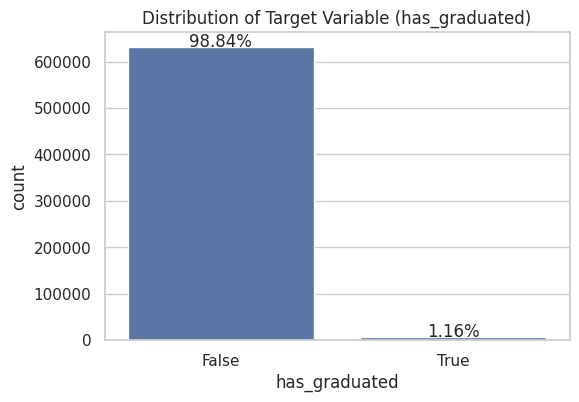

In [ ]:
# Target Distribution (Slide 8, Viz 1)
print("\nTarget Variable Distribution ('has_graduated'):")
plt.figure(figsize=(6, 4))
sns.countplot(x='has_graduated', data=train_features_df)
plt.title('Distribution of Target Variable (has_graduated)')
# Add percentages
total = len(train_features_df)
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center", fontsize=12)
plt.show()

In [ ]:
# Define key features to visualize (adjust based on your domain knowledge/interest)
key_features_univariate = [
    'tx_count_100s',
    'unique_wallets_count_100s',
    'total_sol_vol_100s',
    'net_sol_vol_100s',
    'lp_sol_end_100s',
    'lp_sol_change_pct_100s',
    'price_change_pct_100s',
    'tx_per_second_100s',
    'slot_span_100s',
    'avg_buy_sol_100s',
    'avg_sell_sol_100s',
    'buy_sell_tx_ratio_100s',
    'buy_sell_sol_vol_ratio_100s',
    'first_slot_offset_100s',
    'avg_tx_per_wallet_100s'
]

# Ensure all selected features exist in the dataframe
key_features_univariate = [f for f in key_features_univariate if f in train_features_df.columns]
print(f"Analyzing key features: {key_features_univariate}")

Analyzing key features: ['tx_count_100s', 'unique_wallets_count_100s', 'total_sol_vol_100s', 'net_sol_vol_100s', 'lp_sol_end_100s', 'lp_sol_change_pct_100s', 'price_change_pct_100s', 'tx_per_second_100s', 'slot_span_100s', 'avg_buy_sol_100s', 'avg_sell_sol_100s', 'buy_sell_tx_ratio_100s', 'buy_sell_sol_vol_ratio_100s', 'first_slot_offset_100s', 'avg_tx_per_wallet_100s']



Plotting Histograms/Density Plots (split by target)...


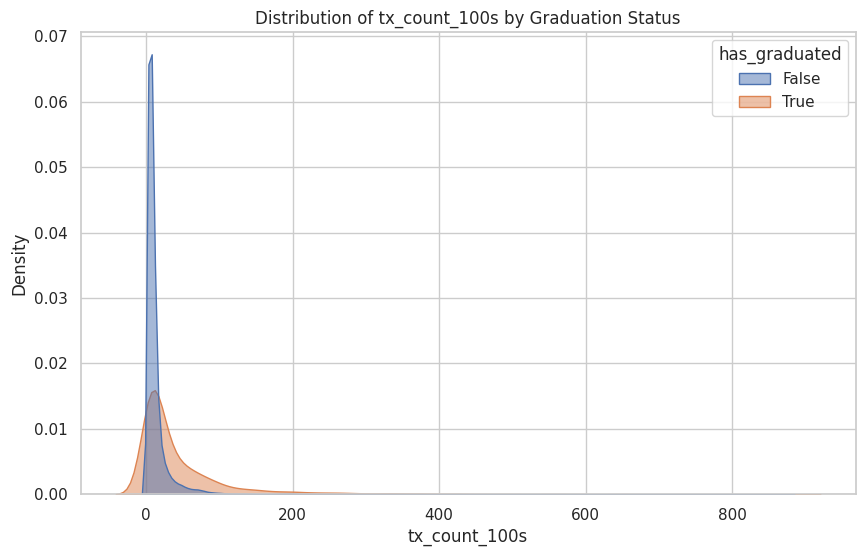

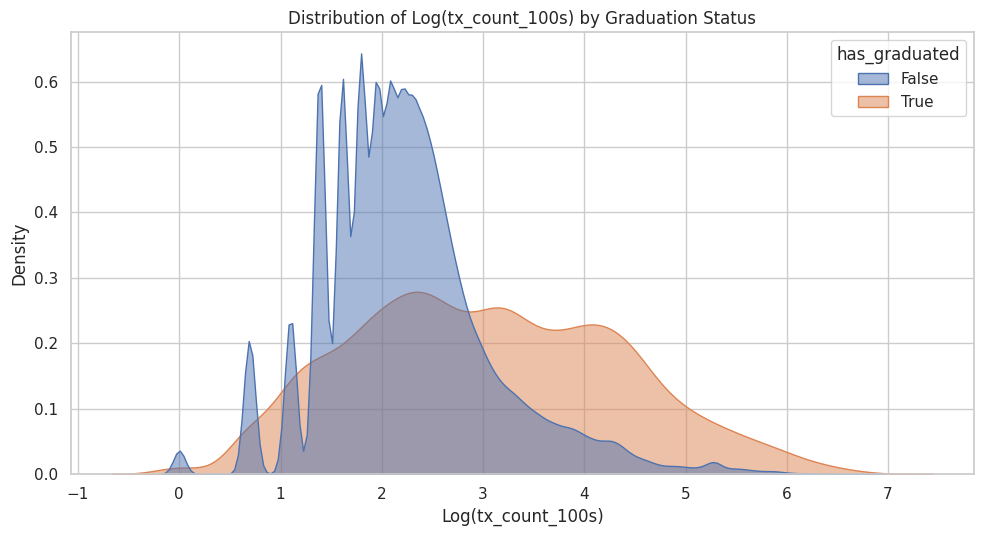

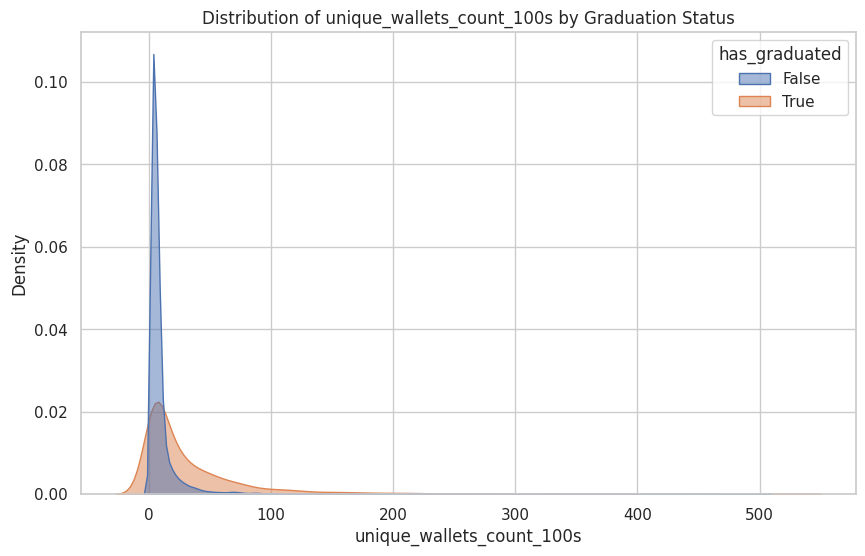

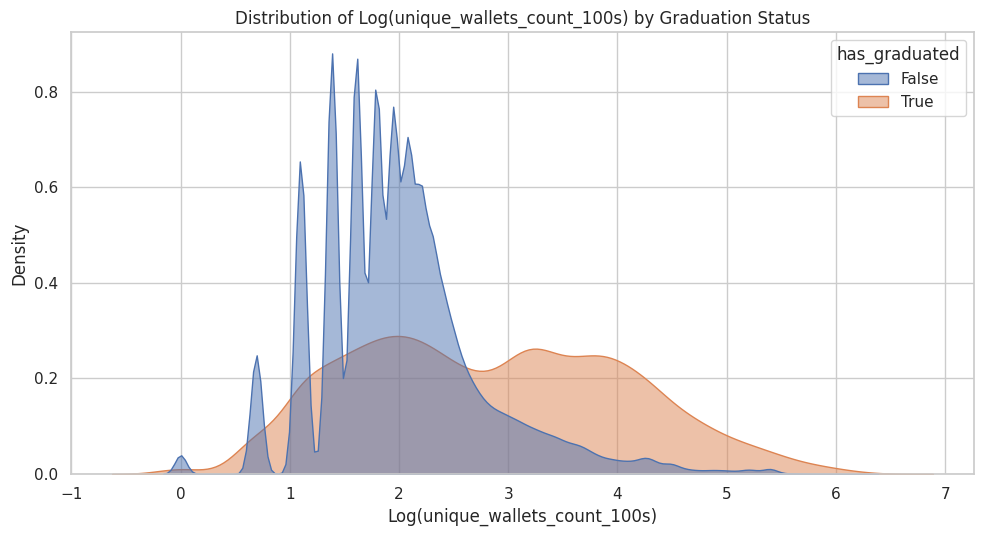

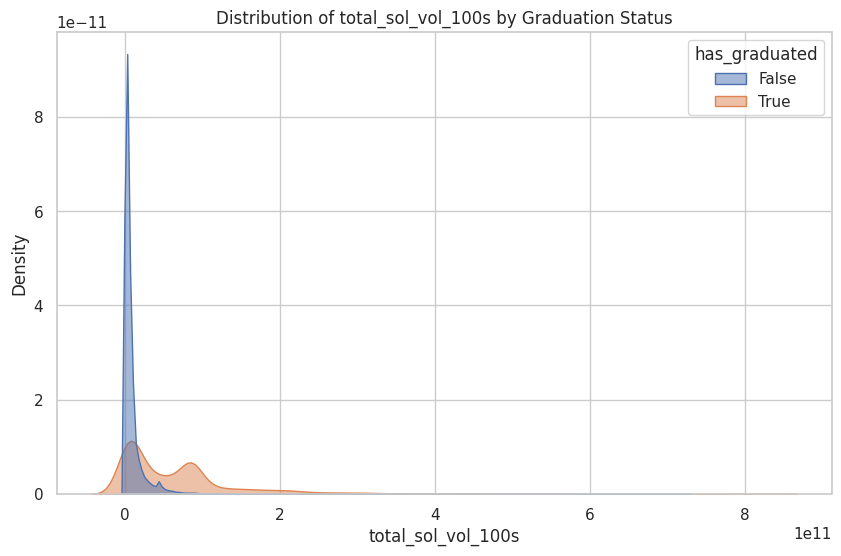

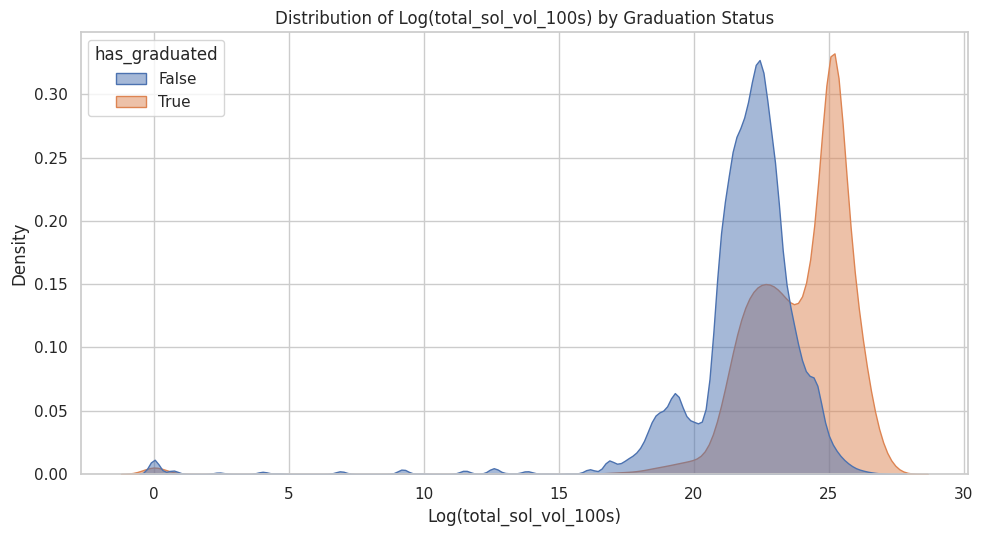

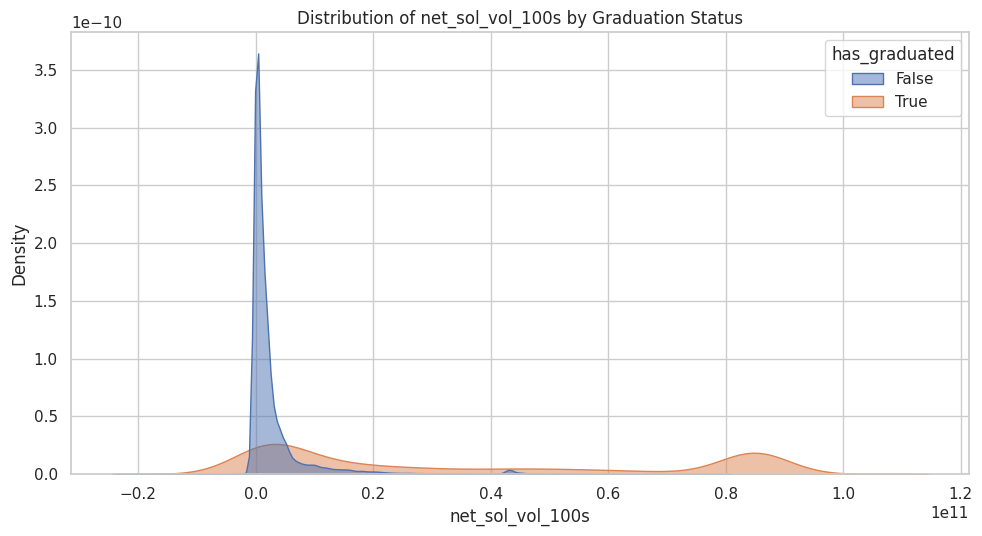

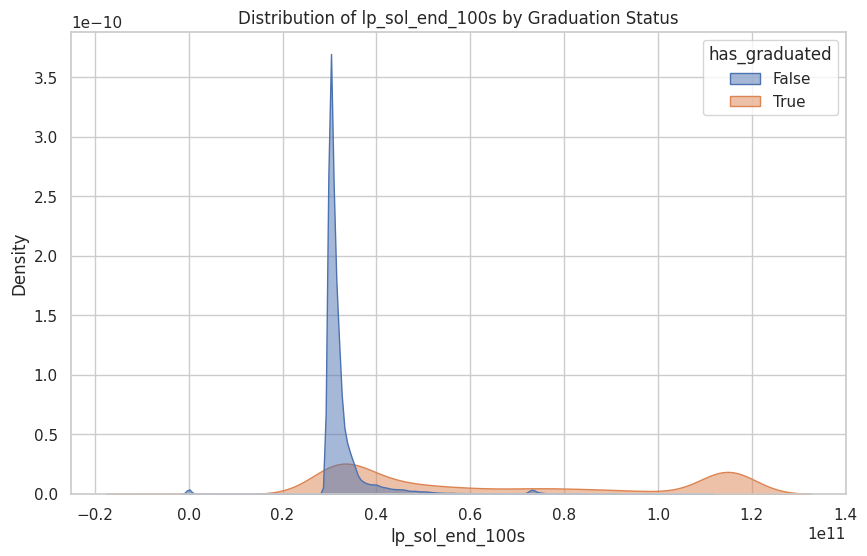

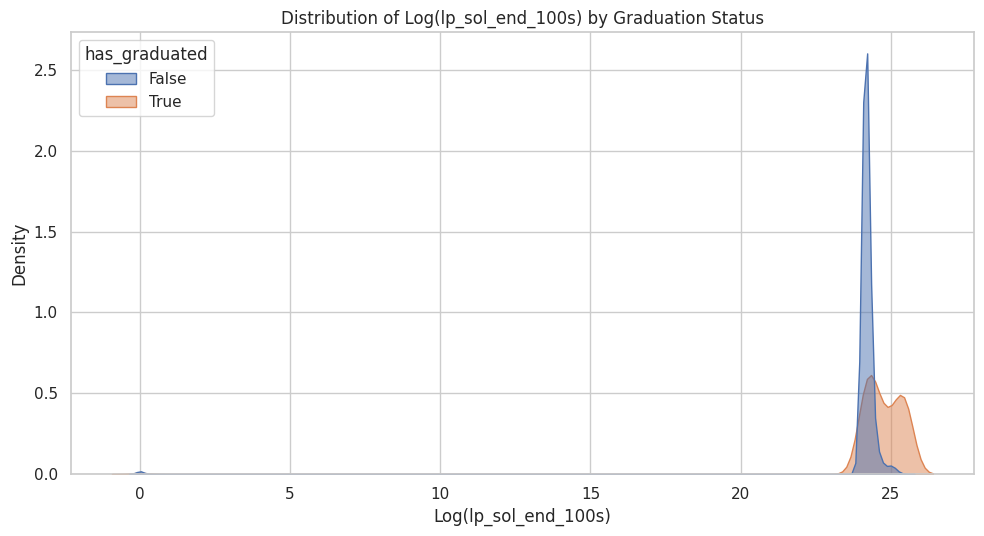

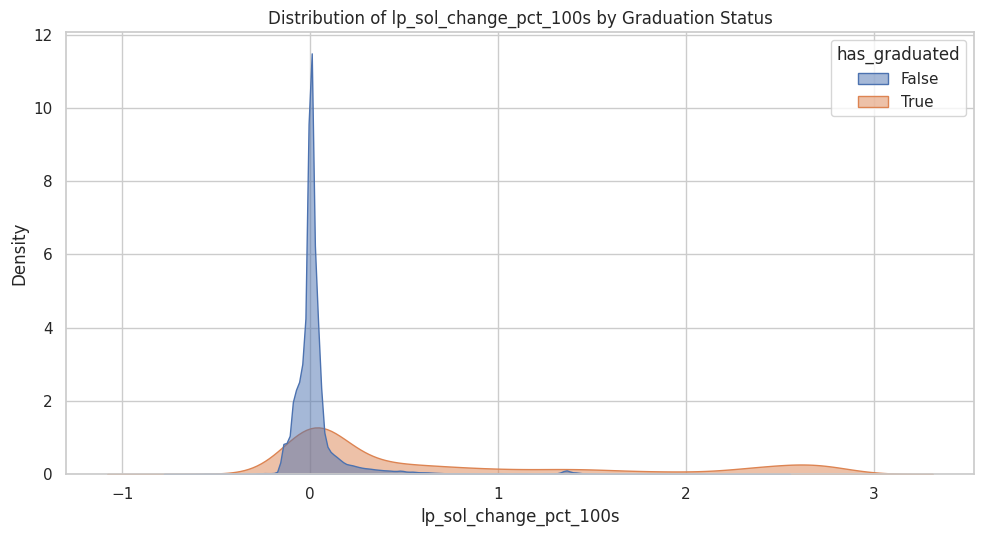

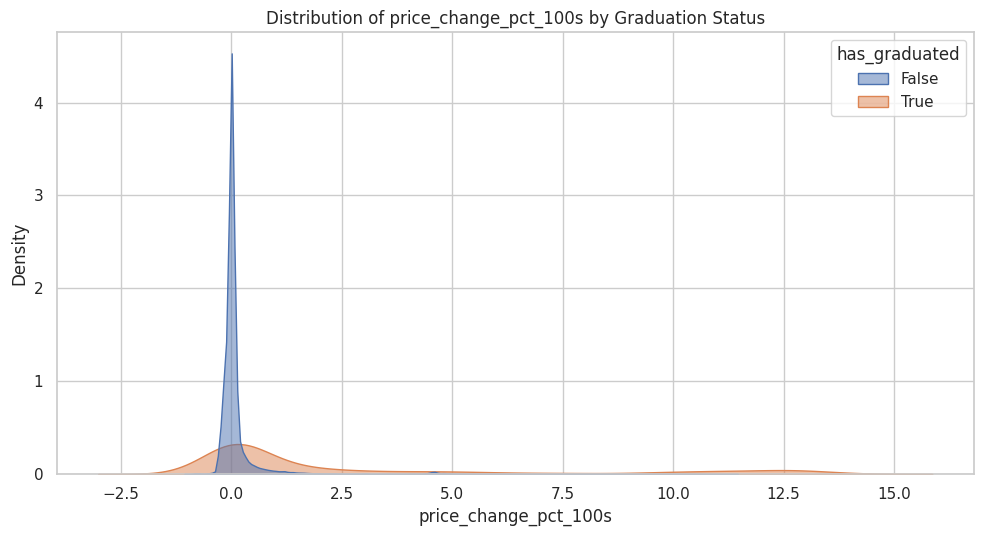

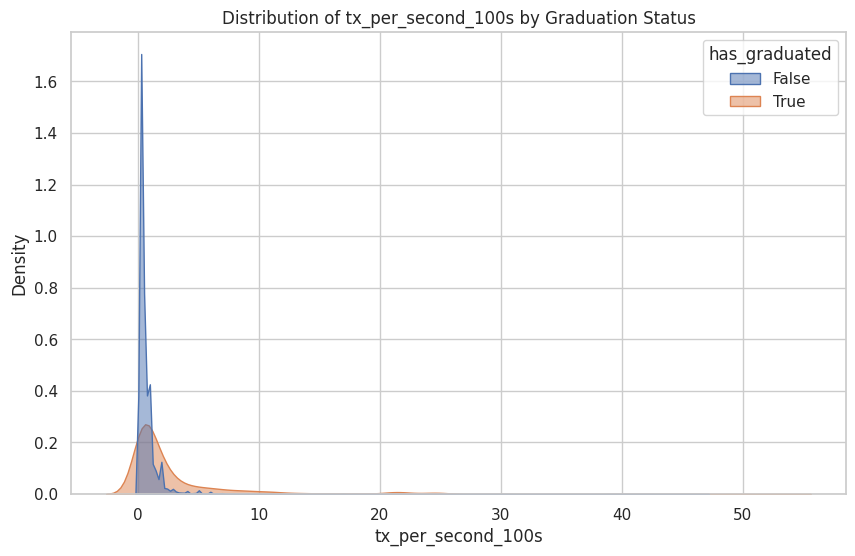

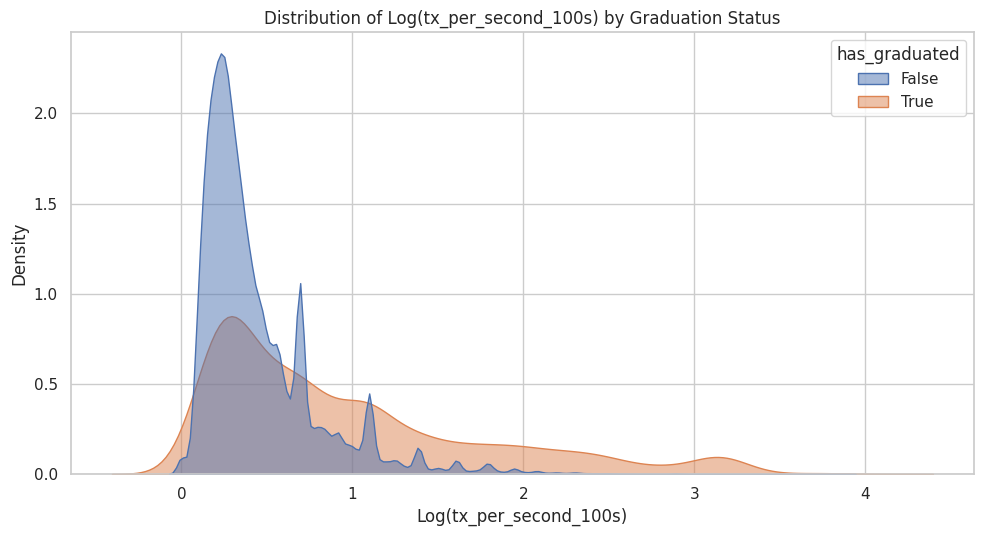

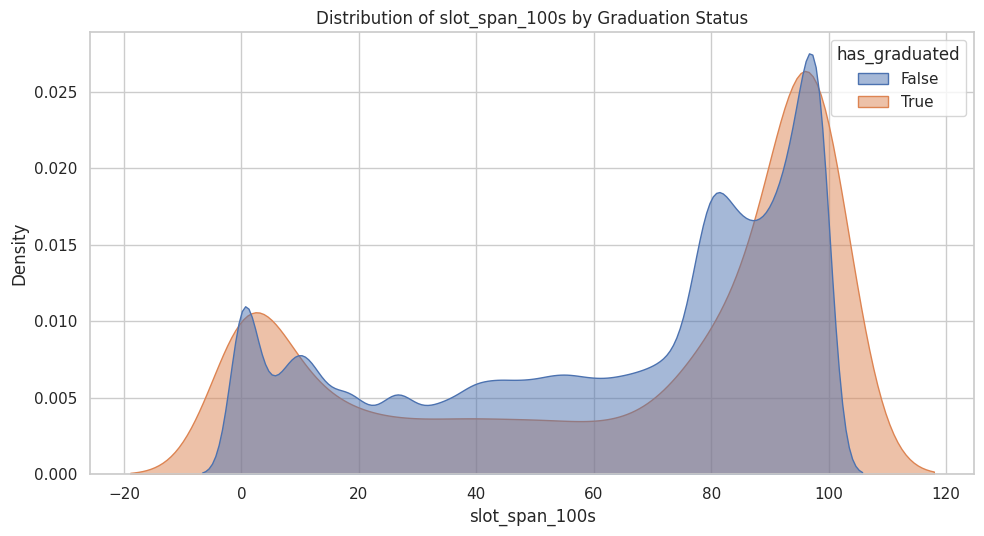

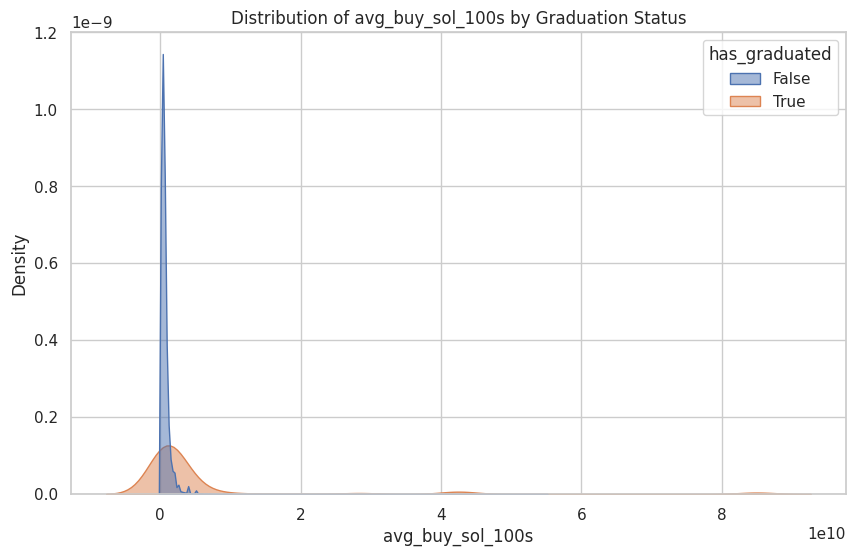

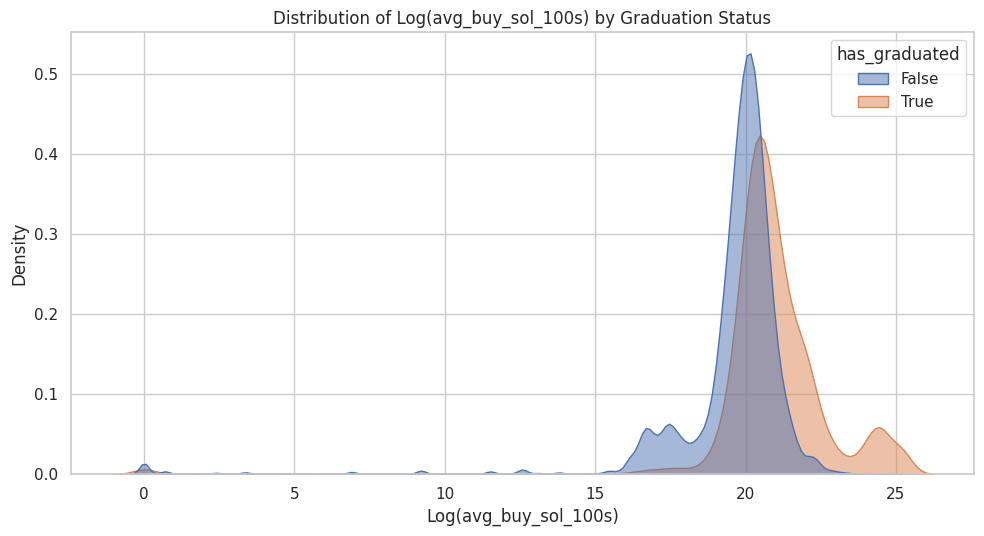

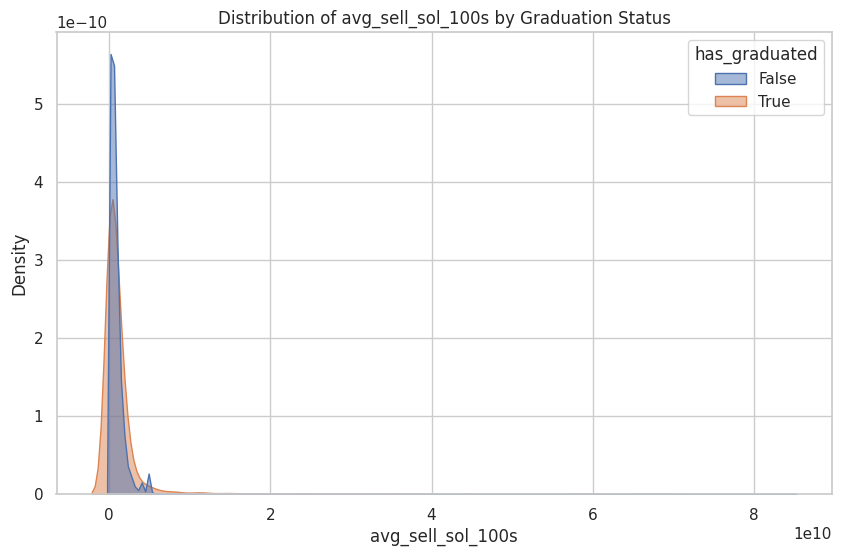

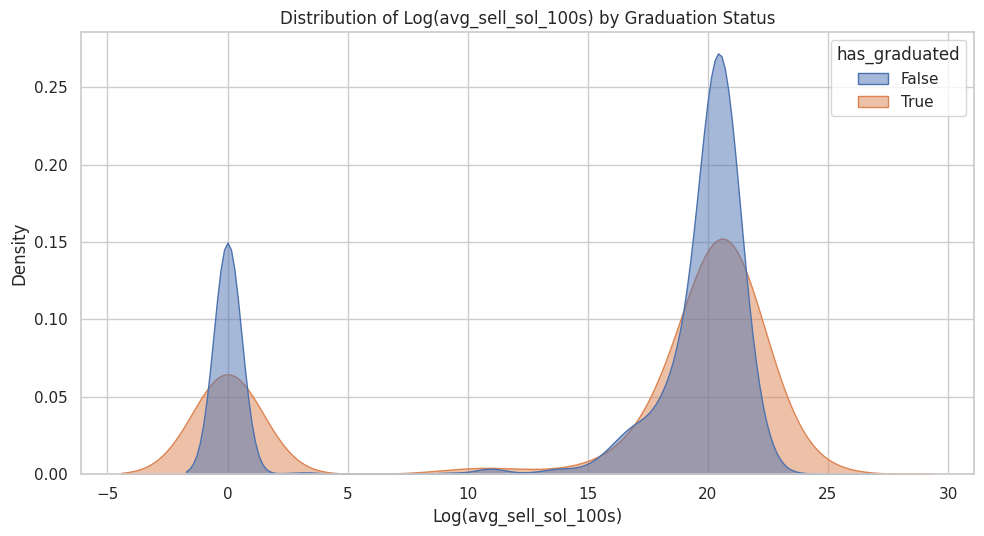

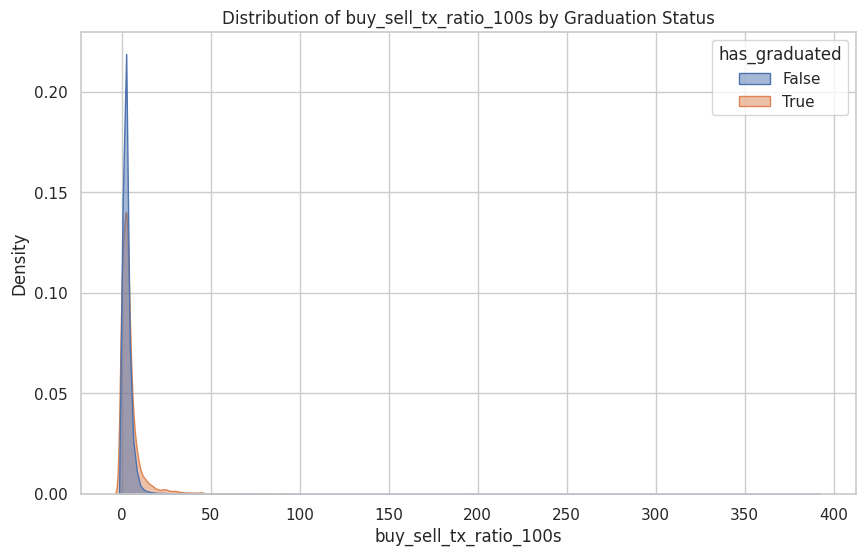

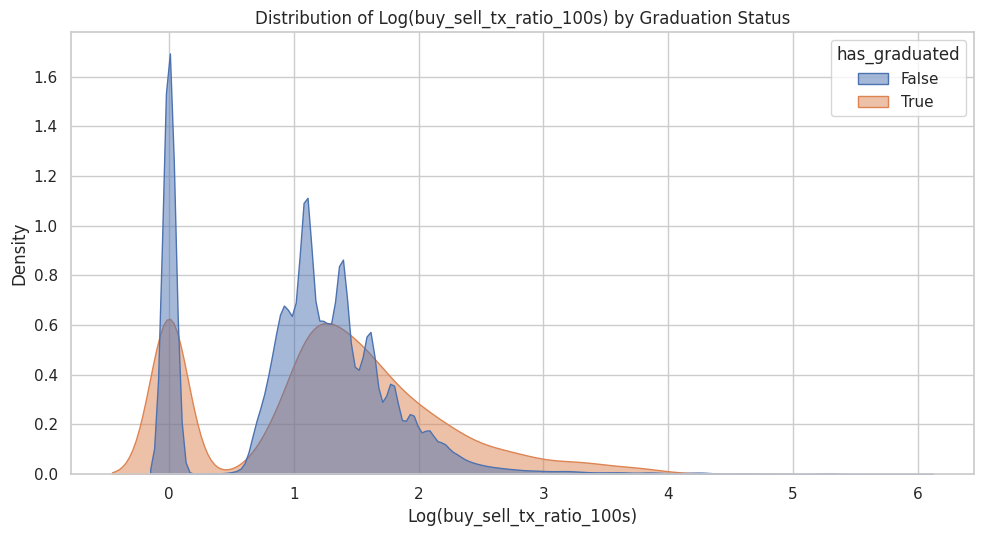

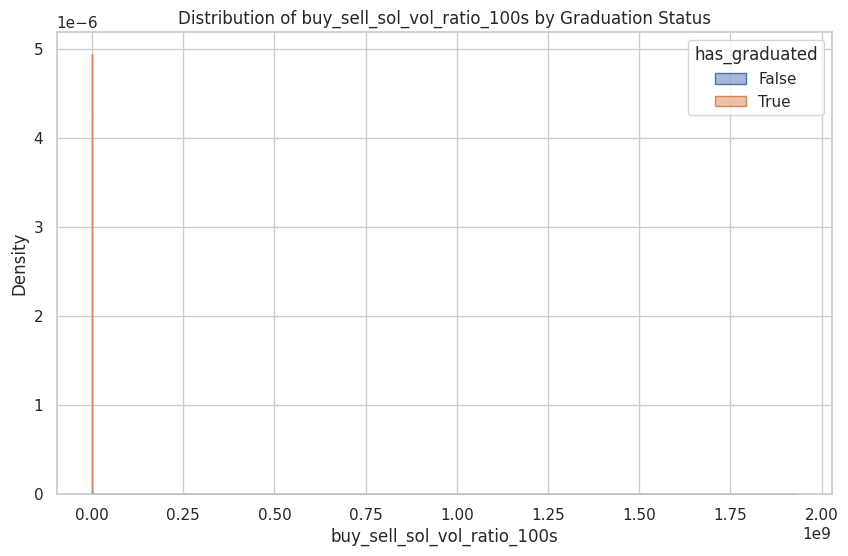

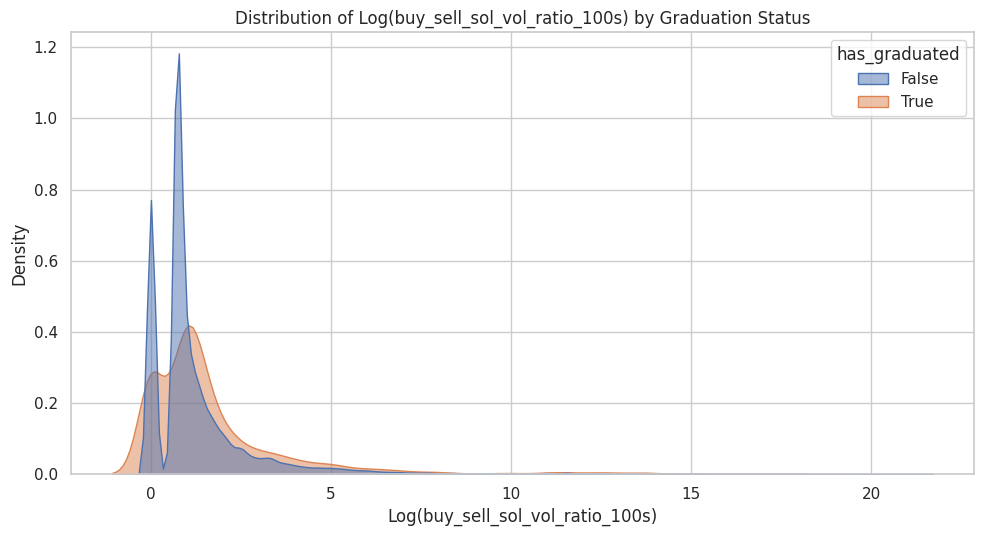

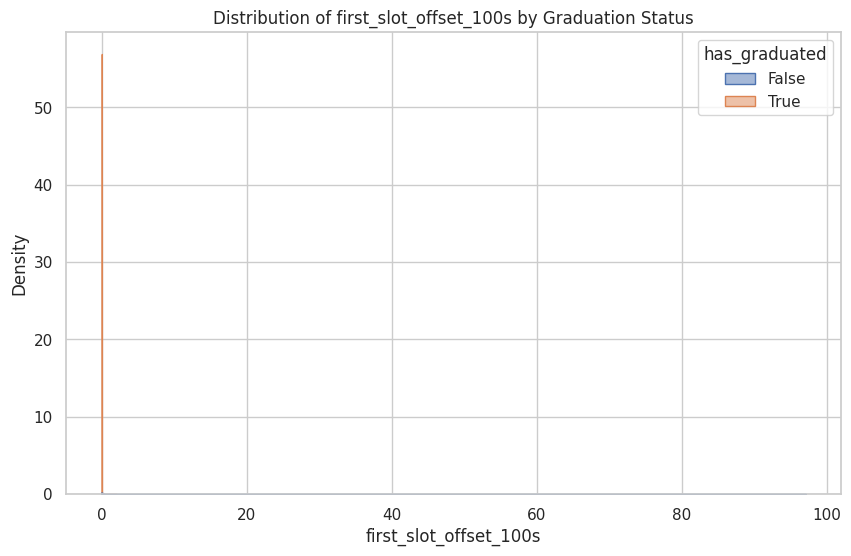

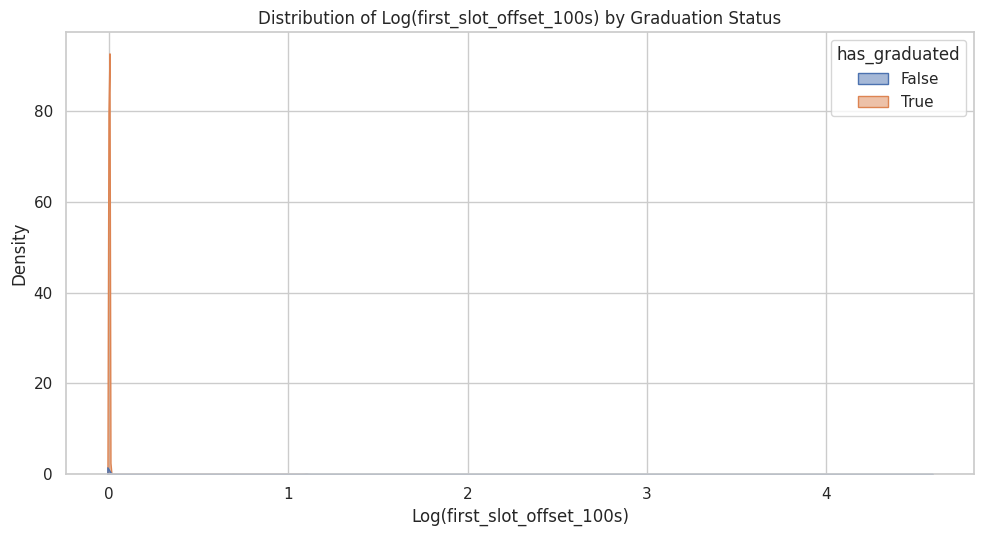

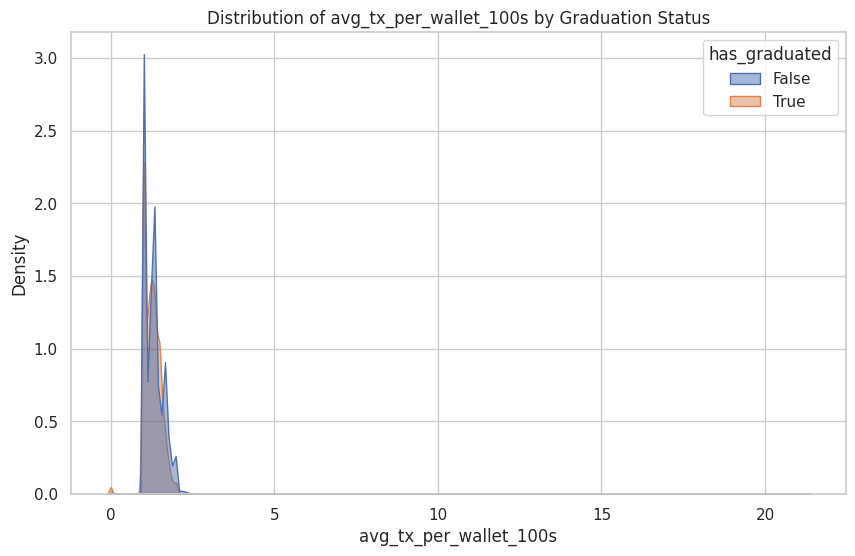

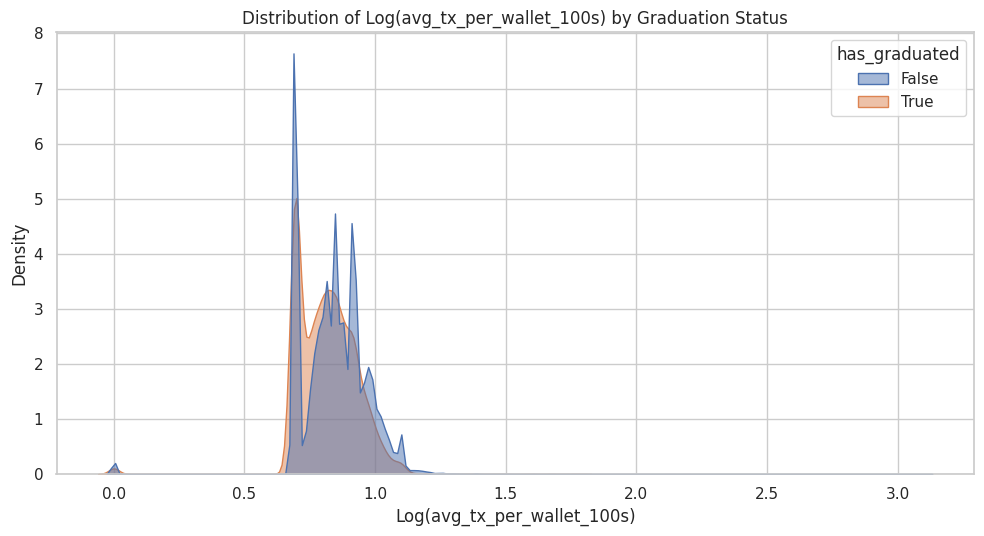

In [ ]:
# Histograms/Density Plots (Slide 8, Viz 2 & 5)
print("\nPlotting Histograms/Density Plots (split by target)...")
for feature in key_features_univariate:
    plt.figure(figsize=(10, 6))
    try:
        # Use kdeplot for smoother comparison
        sns.kdeplot(data=train_features_df, x=feature, hue='has_graduated',
                    fill=True, common_norm=False, alpha=0.5)
        plt.title(f'Distribution of {feature} by Graduation Status')

        # Check for skewness and suggest log scale if helpful
        skewness = train_features_df[feature].skew()
        if abs(skewness) > 2: # Arbitrary threshold for high skewness
            # plt.suptitle(f'(Highly Skewed: {skewness:.2f}. Consider log scale)', y=0.92, fontsize=10)
            # Optional: Create a second plot with log scale
            # Be careful with log(0) or log(negative) if applicable
            if train_features_df[feature].min() >= 0:
                 # Add small epsilon to handle zeros if log scaling
                epsilon = 1e-9
                log_feature_data = np.log1p(train_features_df[feature] + epsilon) # Use log1p for stability near 0
                if not log_feature_data.isnull().all() and not np.isinf(log_feature_data).all(): # Check if log transform is valid
                    plt.figure(figsize=(10, 6))
                    sns.kdeplot(x=log_feature_data, hue=train_features_df['has_graduated'],
                                fill=True, common_norm=False, alpha=0.5)
                    plt.title(f'Distribution of Log({feature}) by Graduation Status')
                    plt.xlabel(f'Log({feature})')

    except Exception as e:
        print(f"  Could not plot {feature}: {e}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()


Plotting Box Plots (split by target)...


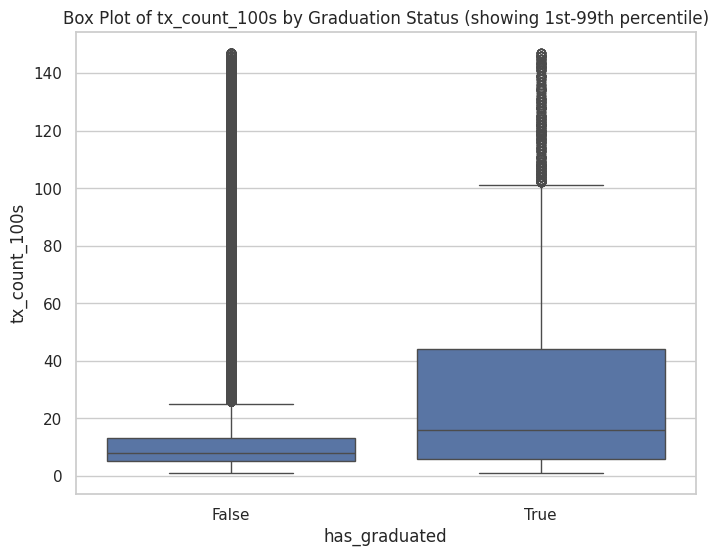

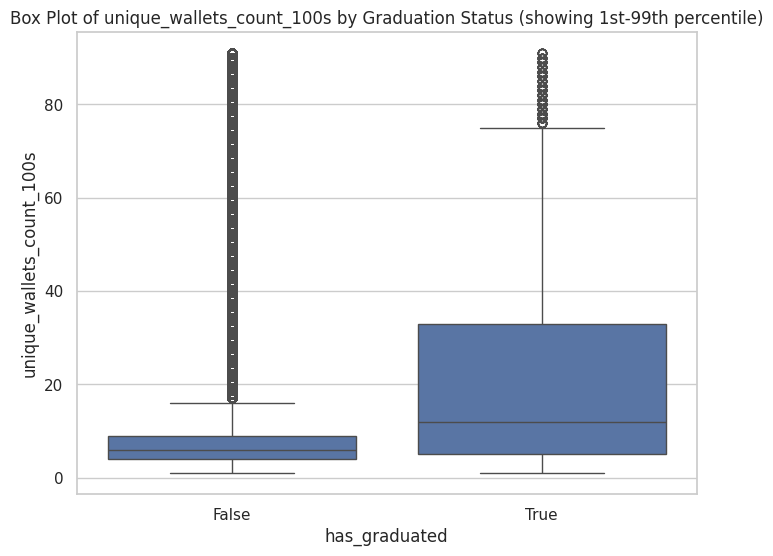

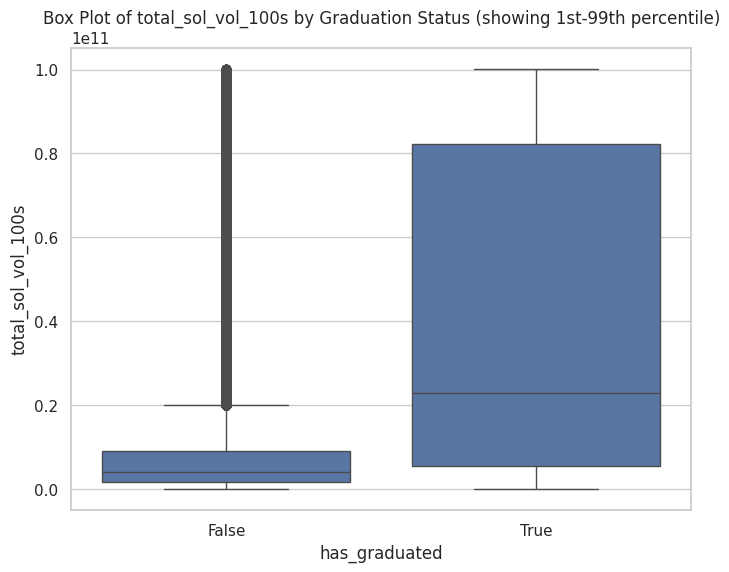

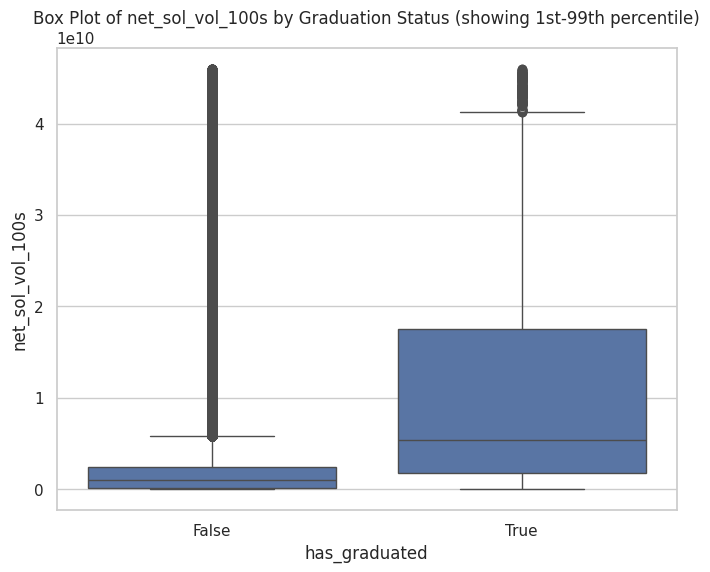

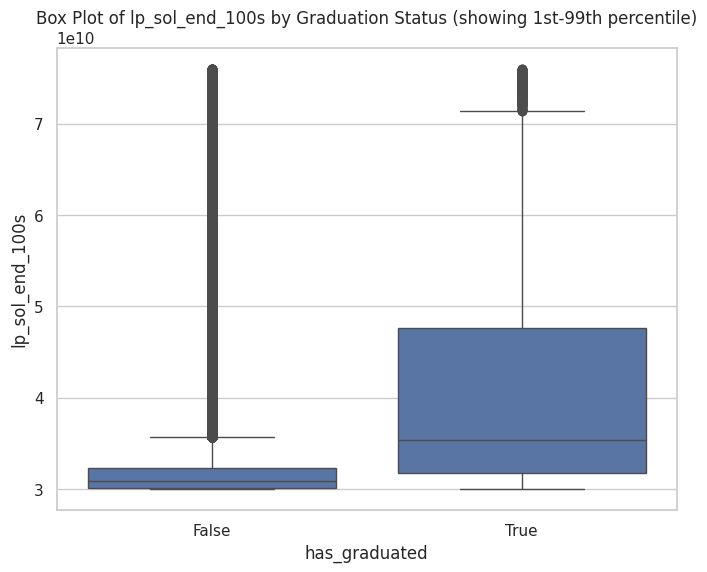

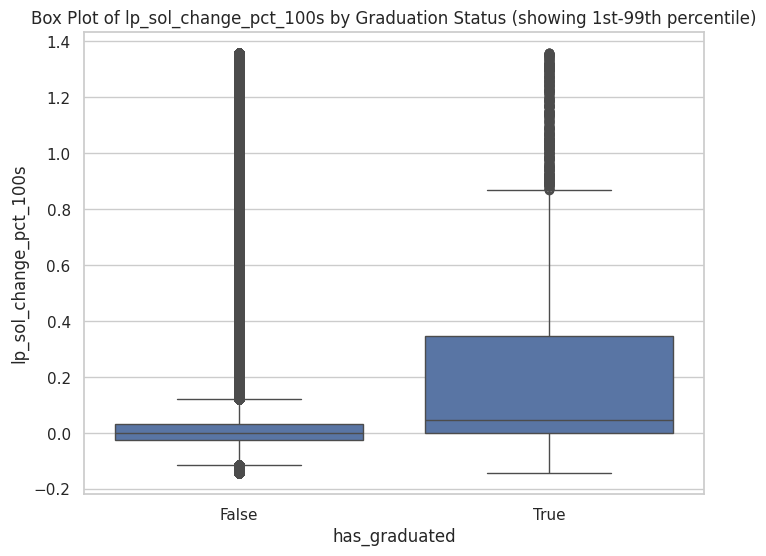

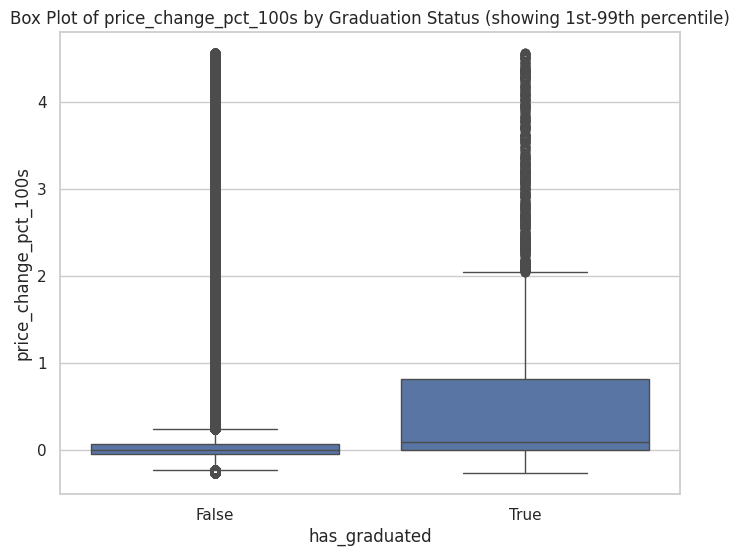

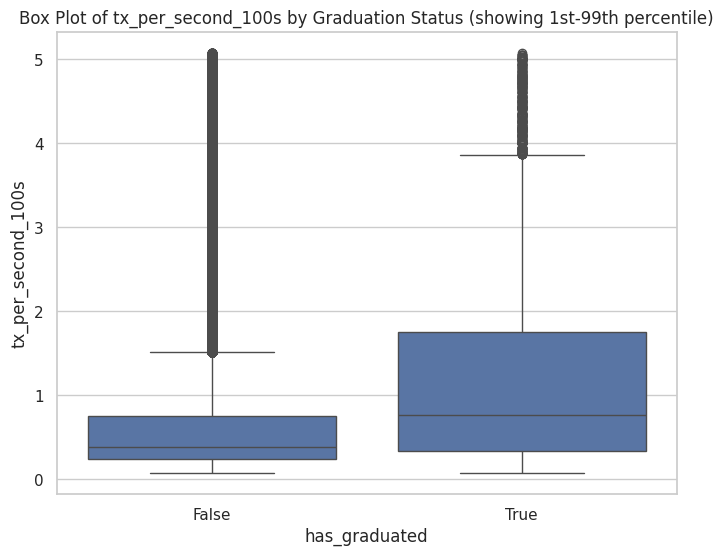

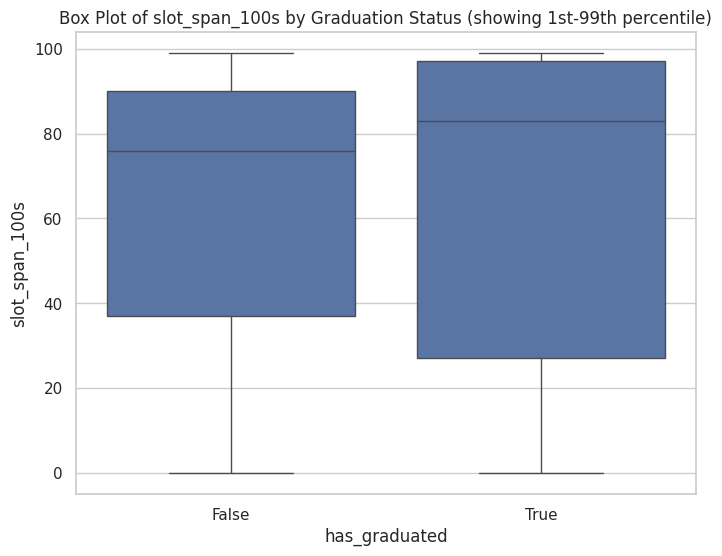

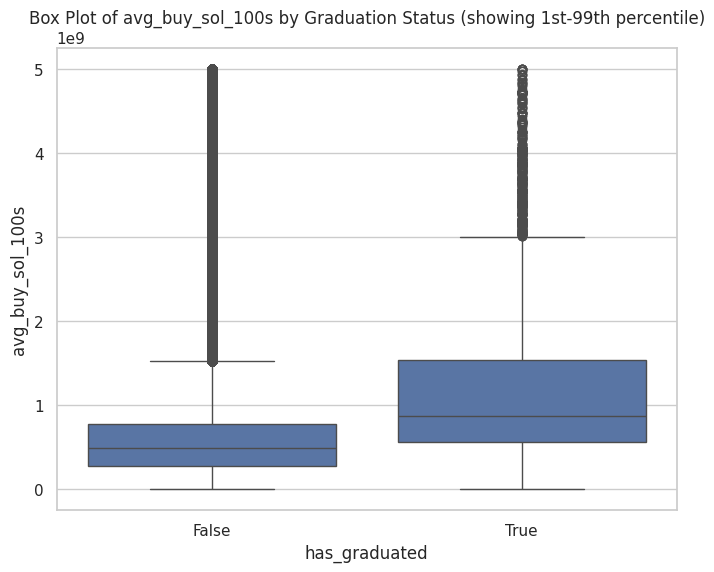

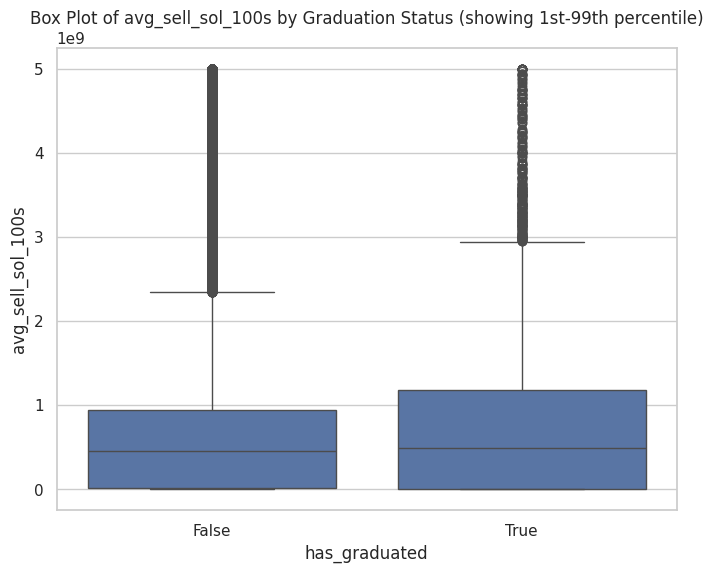

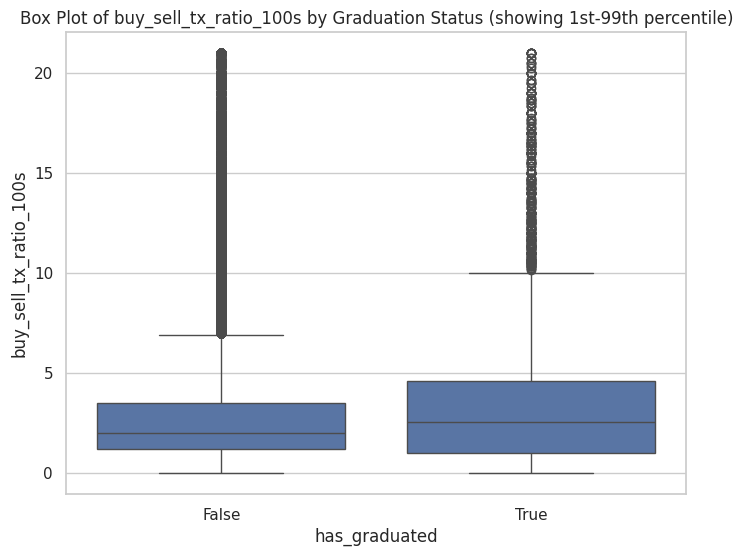

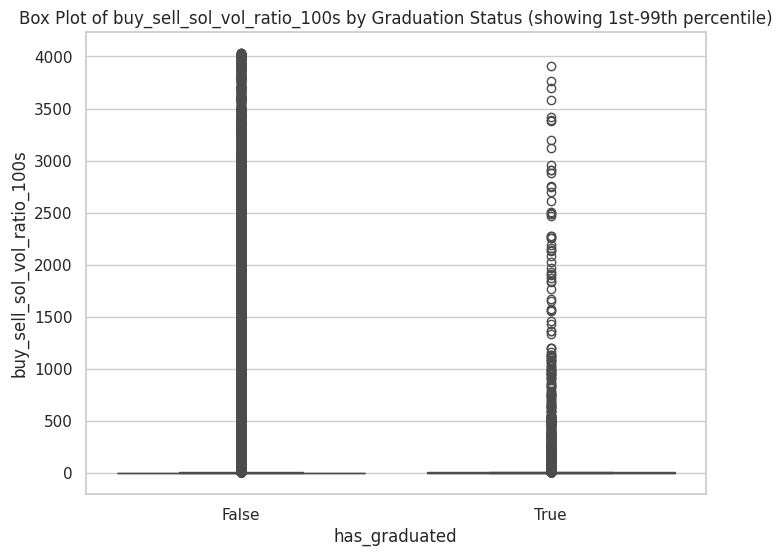

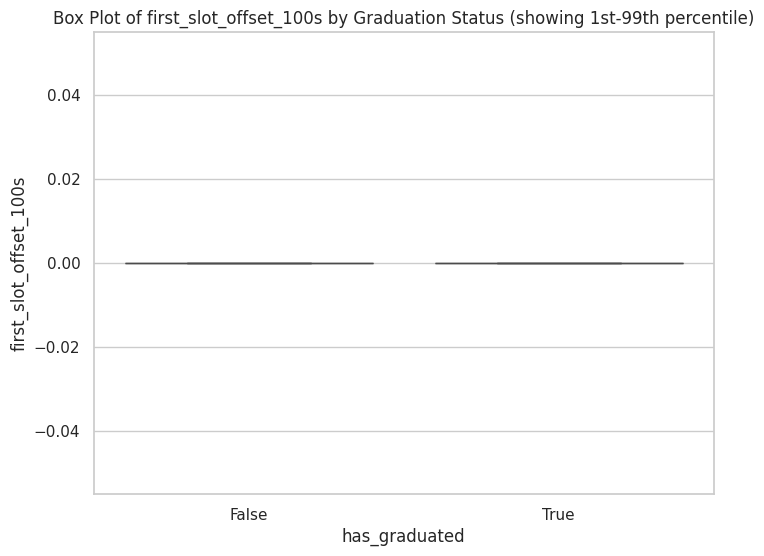

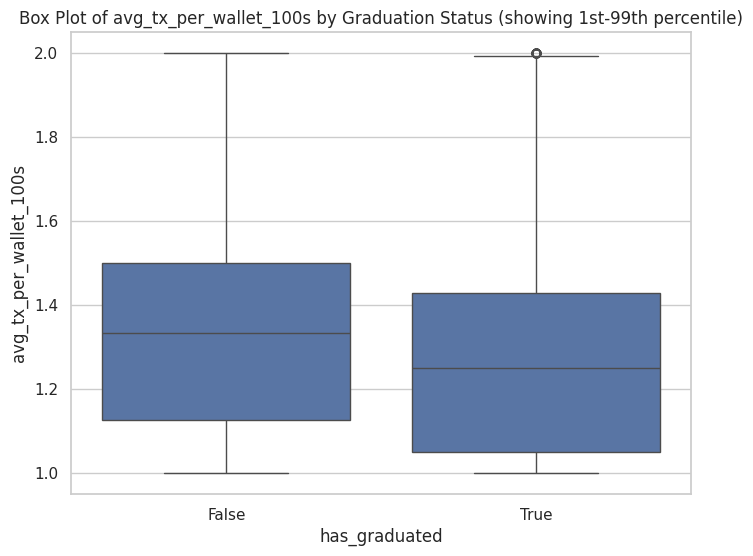

In [ ]:
# Box Plots/Violin Plots (Slide 8, Viz 5 - alternative view)
print("\nPlotting Box Plots (split by target)...")
for feature in key_features_univariate:
    plt.figure(figsize=(8, 6))
    # Check for extreme outliers which might squash the box plot
    q_low = train_features_df[feature].quantile(0.01)
    q_hi  = train_features_df[feature].quantile(0.99)
    df_filtered = train_features_df[(train_features_df[feature] >= q_low) & (train_features_df[feature] <= q_hi)]

    # Decide whether to plot filtered or original data based on outlier impact
    plot_df = df_filtered if len(df_filtered) > 0.5 * len(train_features_df) else train_features_df

    try:
        sns.boxplot(data=plot_df, x='has_graduated', y=feature)
        title = f'Box Plot of {feature} by Graduation Status'
        if plot_df is df_filtered:
             title += " (showing 1st-99th percentile)"
        plt.title(title)
        plt.show()

        # Optional: Violin Plot (combines boxplot with density)
        # plt.figure(figsize=(8, 6))
        # sns.violinplot(data=plot_df, x='has_graduated', y=feature, inner='quartile')
        # title = f'Violin Plot of {feature} by Graduation Status'
        # if plot_df is df_filtered:
        #      title += " (showing 1st-99th percentile)"
        # plt.title(title)
        # plt.show()

    except Exception as e:
        print(f"  Could not plot box/violin for {feature}: {e}")


Calculating Feature-Target Correlations...
Top 20 Features Correlated with Graduation (Positive):
price_end_100s                 0.457609
sol_vol_per_second_100s        0.400594
net_sol_vol_100s               0.399954
lp_sol_end_100s                0.386759
price_change_100s              0.383663
price_change_pct_100s          0.354095
max_lp_sol_100s                0.348179
sol_vol_per_slot_100s          0.341994
buy_sol_vol_100s               0.339439
lp_sol_change_100s             0.321636
lp_sol_change_pct_100s         0.309737
lp_sol_rate_per_second_100s    0.300149
net_token_vol_100s             0.291388
max_buy_sol_tx_100s            0.288505
avg_sol_vol_per_tx_100s        0.274747
avg_buy_sol_100s               0.274313
total_sol_vol_100s             0.273003
avg_sol_vol_per_wallet_100s    0.259655
price_start_100s               0.253165
lp_sol_rate_per_slot_100s      0.247194
Name: has_graduated_numeric, dtype: float64

Top 20 Features Correlated with Graduation (Negative):
b

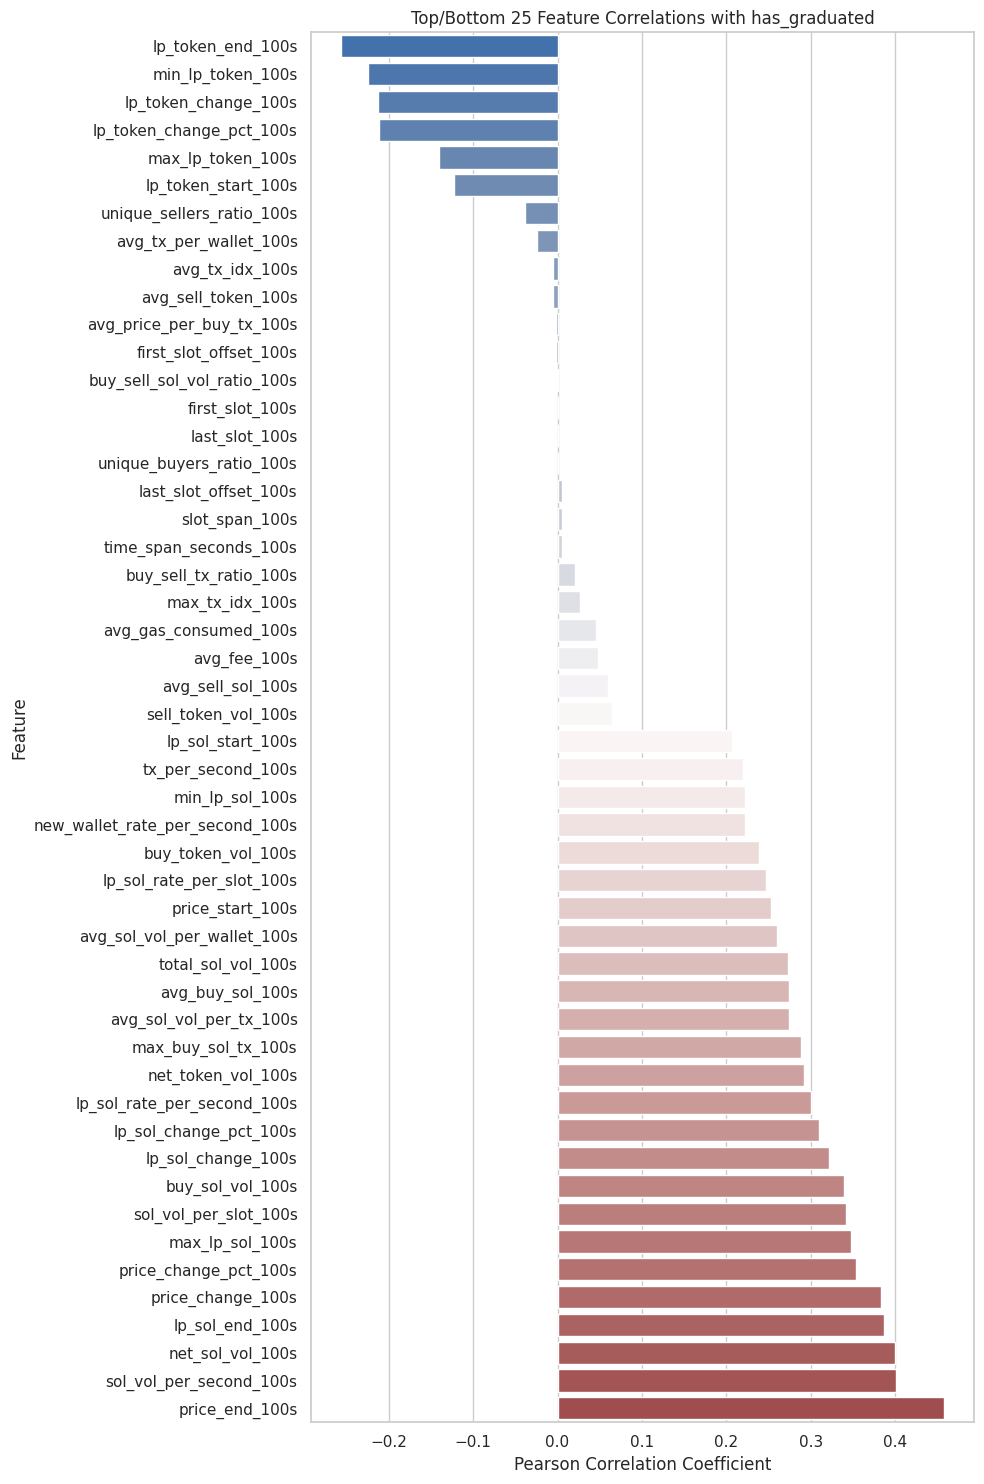

In [ ]:

print("\n--- Step 4: Correlation Analysis ---")
# Create numeric target variable
train_features_df['has_graduated_numeric'] = train_features_df['has_graduated'].astype(int)

# Feature-Target Correlation (Slide 8, Viz 4 - Target Bar)
print("\nCalculating Feature-Target Correlations...")
try:
    # Select only numerical cols + the numeric target
    numerical_and_target = numerical_cols + ['has_graduated_numeric']
    corr_matrix = train_features_df[numerical_and_target].corr(method='pearson') # or 'spearman'

    # Get correlations with the target variable
    target_corr = corr_matrix['has_graduated_numeric'].drop('has_graduated_numeric').sort_values(ascending=False)

    print("Top 20 Features Correlated with Graduation (Positive):")
    print(target_corr.head(20))
    print("\nTop 20 Features Correlated with Graduation (Negative):")
    print(target_corr.tail(20))

    # Plot top N and bottom N correlations
    n_plot = 25 # Number of top/bottom features to plot
    top_corr = pd.concat([target_corr.head(n_plot), target_corr.tail(n_plot)]).sort_values()

    plt.figure(figsize=(10, max(8, len(top_corr) * 0.3))) # Adjust height based on number of features
    sns.barplot(x=top_corr.values, y=top_corr.index, palette="vlag")
    plt.title(f'Top/Bottom {n_plot} Feature Correlations with has_graduated')
    plt.xlabel('Pearson Correlation Coefficient')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not calculate or plot feature-target correlations: {e}")


Calculating Feature-Feature Correlation Heatmap...


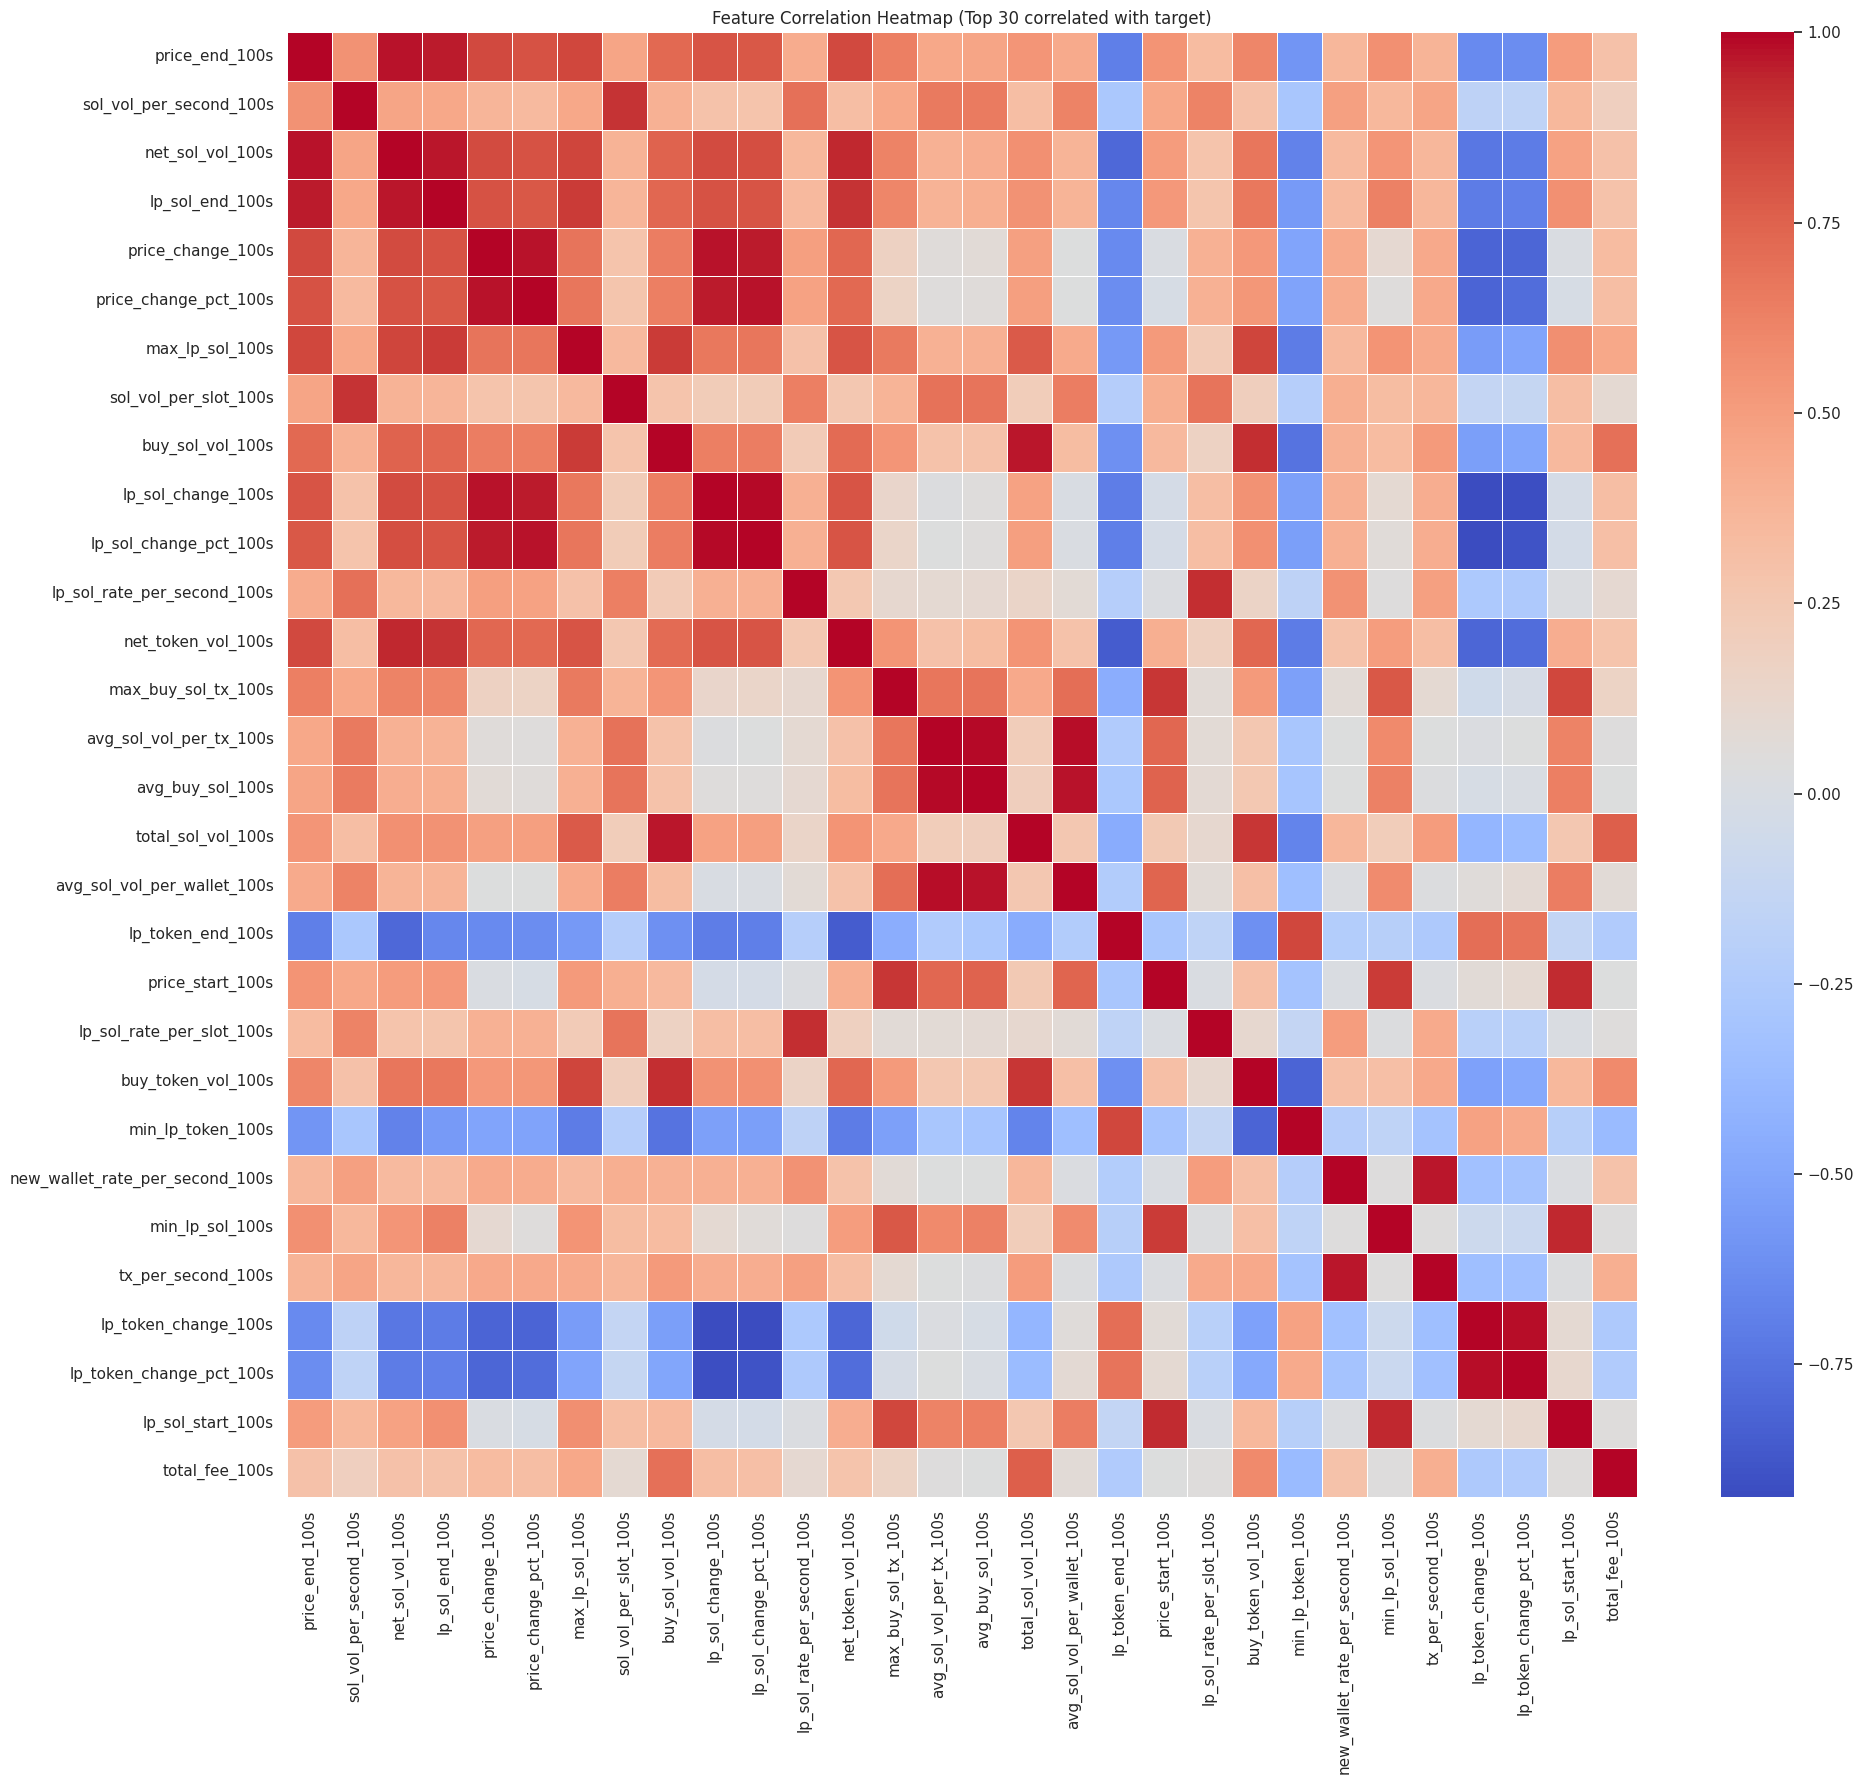

In [ ]:
# Feature-Feature Correlation Heatmap (Slide 8, Viz 4 - Heatmap)
print("\nCalculating Feature-Feature Correlation Heatmap...")
# Often better to use a subset of features for readability, e.g., top correlated or key features
# features_for_heatmap = key_features_univariate # Option 1: Use key features from Step 3
features_for_heatmap = target_corr.abs().sort_values(ascending=False).head(30).index.tolist() # Option 2: Use top 30 most correlated features (magnitude)

# Check if features exist before creating heatmap
features_for_heatmap = [f for f in features_for_heatmap if f in train_features_df.columns]

if len(features_for_heatmap) > 1:
    try:
        subset_corr_matrix = train_features_df[features_for_heatmap].corr(method='pearson')

        plt.figure(figsize=(min(20, len(features_for_heatmap)*0.8), min(18, len(features_for_heatmap)*0.7)))
        sns.heatmap(subset_corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5) # Annot=True can be messy for many features
        plt.title(f'Feature Correlation Heatmap (Top {len(features_for_heatmap)} correlated with target)')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot feature-feature heatmap: {e}")
else:
    print("Not enough features selected or available for heatmap.")


--- Step 5: Bivariate Analysis (Feature Pairs vs. Target) ---

Plotting Scatter Plots for Feature Pairs (colored by target)...


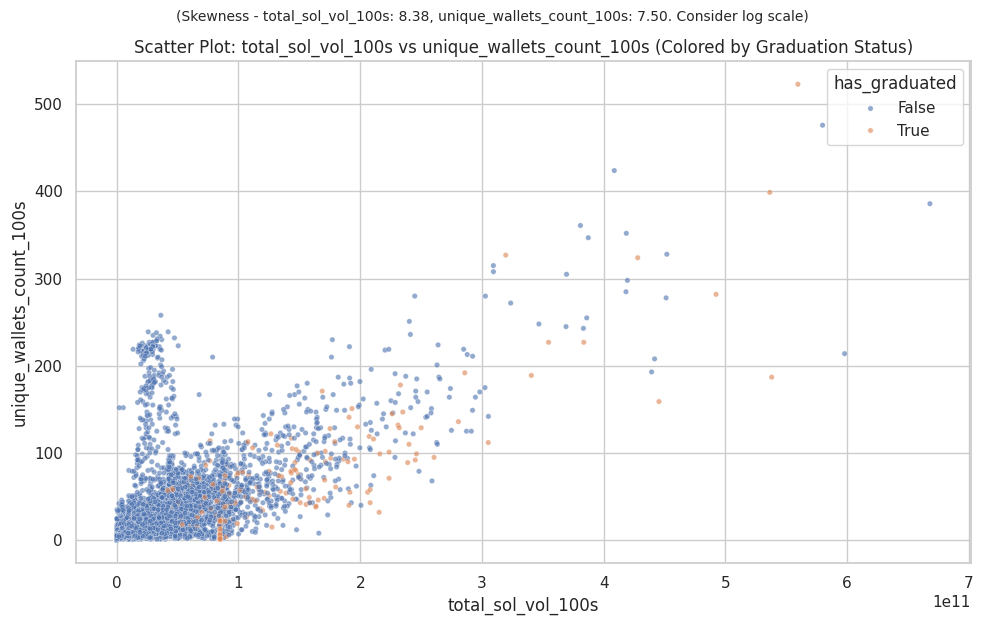

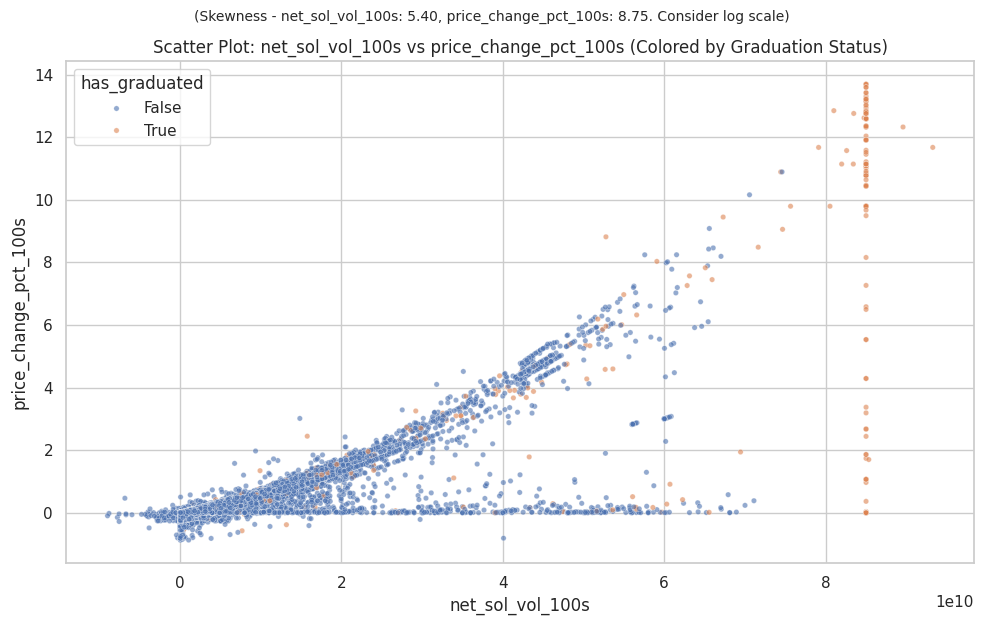

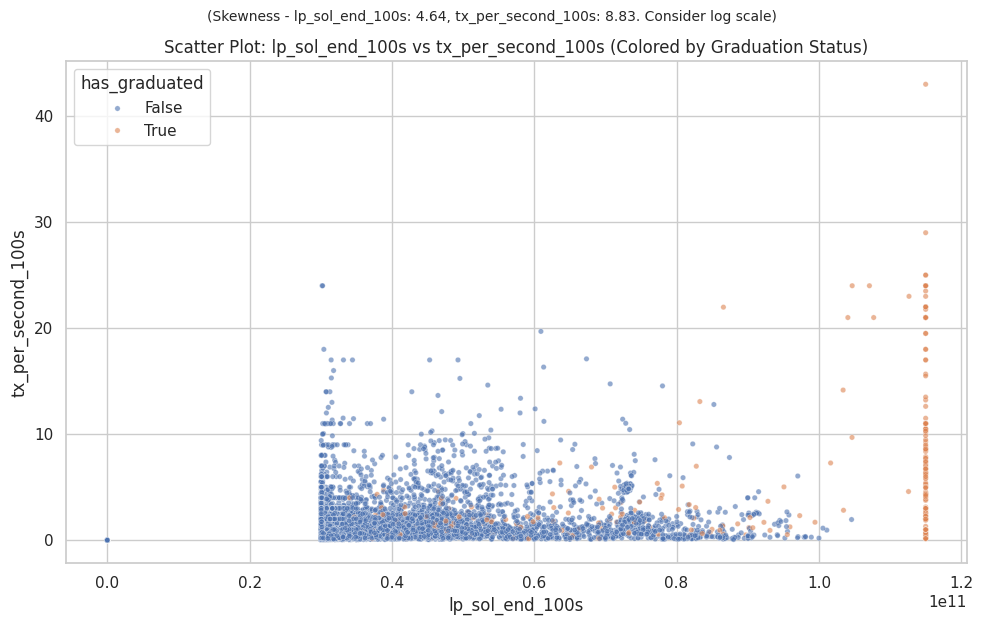

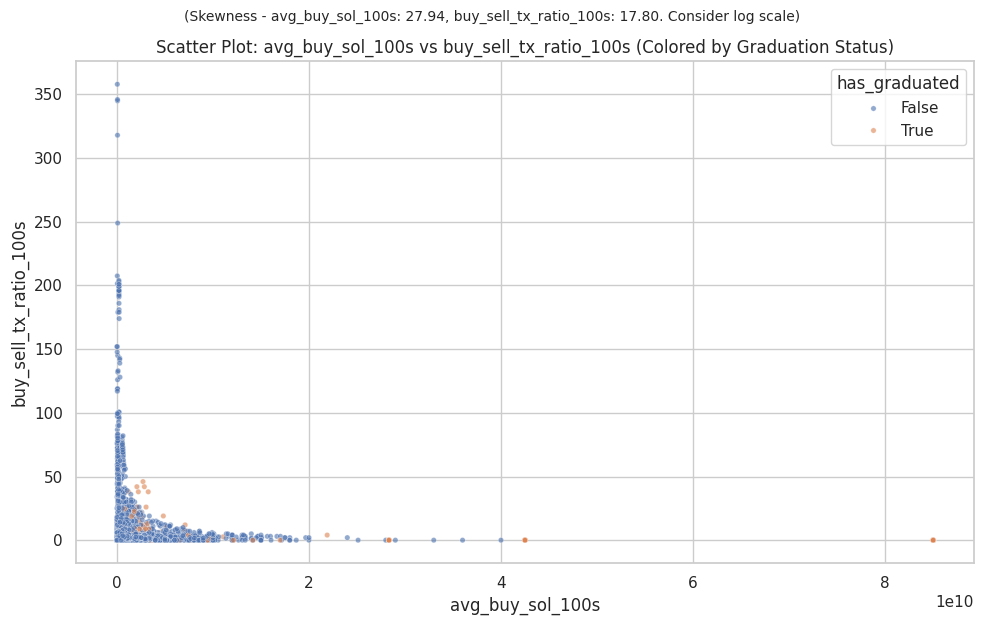

In [ ]:
print("\n--- Step 5: Bivariate Analysis (Feature Pairs vs. Target) ---")

# Define promising pairs based on Step 4 (low inter-correlation, high target correlation) or hypotheses
# Example pairs:
promising_feature_pairs = [
    ('total_sol_vol_100s', 'unique_wallets_count_100s'),
    ('net_sol_vol_100s', 'price_change_pct_100s'),
    ('lp_sol_end_100s', 'tx_per_second_100s'),
    ('avg_buy_sol_100s', 'buy_sell_tx_ratio_100s')
]

print("\nPlotting Scatter Plots for Feature Pairs (colored by target)...")
for feat1, feat2 in promising_feature_pairs:
    if feat1 in train_features_df.columns and feat2 in train_features_df.columns:
        plt.figure(figsize=(10, 7))
        try:
            # Use a sample if the dataset is very large to speed up plotting
            sample_df = train_features_df.sample(min(len(train_features_df), 50000), random_state=42) # Sample 50k points
            sns.scatterplot(data=sample_df, x=feat1, y=feat2, hue='has_graduated', alpha=0.6, s=15) # smaller points
            plt.title(f'Scatter Plot: {feat1} vs {feat2} (Colored by Graduation Status)')

            # Add log scale option suggestion if skewed
            skew1 = train_features_df[feat1].skew()
            skew2 = train_features_df[feat2].skew()
            if abs(skew1) > 2 or abs(skew2) > 2:
                 plt.suptitle(f'(Skewness - {feat1}: {skew1:.2f}, {feat2}: {skew2:.2f}. Consider log scale)', y=0.92, fontsize=10)

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
        except Exception as e:
            print(f"  Could not plot scatter for {feat1} vs {feat2}: {e}")
    else:
        print(f"  Skipping pair ({feat1}, {feat2}): one or both features not found.")


--- Step 6: Analysis of Specific Hypotheses ---
Refer back to plots generated in Step 3 for distributions/boxplots of:
 - Buy vs. Sell Pressure: 'buy_sell_tx_ratio_100s', 'buy_sell_sol_vol_ratio_100s'
 - Liquidity Growth: 'lp_sol_end_100s', 'lp_sol_change_pct_100s', 'lp_sol_rate_per_second_100s'
 - Early Activity Timing: 'first_slot_offset_100s'
 - Engagement: 'unique_wallets_count_100s', 'avg_tx_per_wallet_100s'

Correlation between 'lp_sol_end_100s' and 'has_graduated': 0.3868
 -> Suggests a potentially important positive relationship.

Distribution of 'first_slot_offset_100s' for Graduated Tokens:
first_slot_offset_100s
0.0    0.999595
1.0    0.000270
2.0    0.000135
Name: proportion, dtype: float64


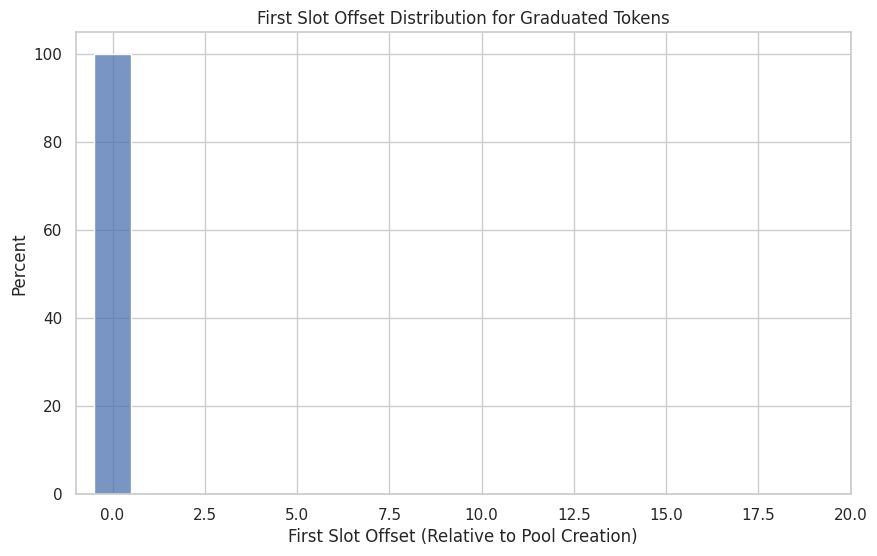

In [ ]:
print("\n--- Step 6: Analysis of Specific Hypotheses ---")
# This step primarily involves interpreting the plots generated in Steps 3, 4, and 5.
# We can add specific comments or re-plot key hypothesis-related features if needed.

print("Refer back to plots generated in Step 3 for distributions/boxplots of:")
print(" - Buy vs. Sell Pressure: 'buy_sell_tx_ratio_100s', 'buy_sell_sol_vol_ratio_100s'")
print(" - Liquidity Growth: 'lp_sol_end_100s', 'lp_sol_change_pct_100s', 'lp_sol_rate_per_second_100s'")
print(" - Early Activity Timing: 'first_slot_offset_100s'")
print(" - Engagement: 'unique_wallets_count_100s', 'avg_tx_per_wallet_100s'")

# Example: Let's explicitly look at the correlation value for lp_sol_end_100s
if 'target_corr' in locals() and 'lp_sol_end_100s' in target_corr.index:
    lp_corr = target_corr['lp_sol_end_100s']
    print(f"\nCorrelation between 'lp_sol_end_100s' and 'has_graduated': {lp_corr:.4f}")
    if lp_corr > 0.1:
        print(" -> Suggests a potentially important positive relationship.")
    elif lp_corr < -0.1:
         print(" -> Suggests a potentially important negative relationship.")
    else:
         print(" -> Suggests a weak linear relationship.")

# Example: Check distribution of 'first_slot_offset_100s' for graduated tokens
if 'first_slot_offset_100s' in train_features_df.columns:
    print("\nDistribution of 'first_slot_offset_100s' for Graduated Tokens:")
    print(train_features_df[train_features_df['has_graduated'] == True]['first_slot_offset_100s'].value_counts(normalize=True).head(10))
    plt.figure(figsize=(10, 6))
    sns.histplot(data=train_features_df[train_features_df['has_graduated'] == True], x='first_slot_offset_100s', discrete=True, stat='percent')
    plt.title('First Slot Offset Distribution for Graduated Tokens')
    plt.xlabel('First Slot Offset (Relative to Pool Creation)')
    plt.xlim(-1, 20) # Focus on early slots
    plt.show()

In [ ]:
!pip install umap-learn


--- Step 7: Dimensionality Reduction (Optional Visualization) ---
Using 67 features for dimensionality reduction.
Scaling features...
Applying PCA...
PCA Explained Variance Ratio: 0.433


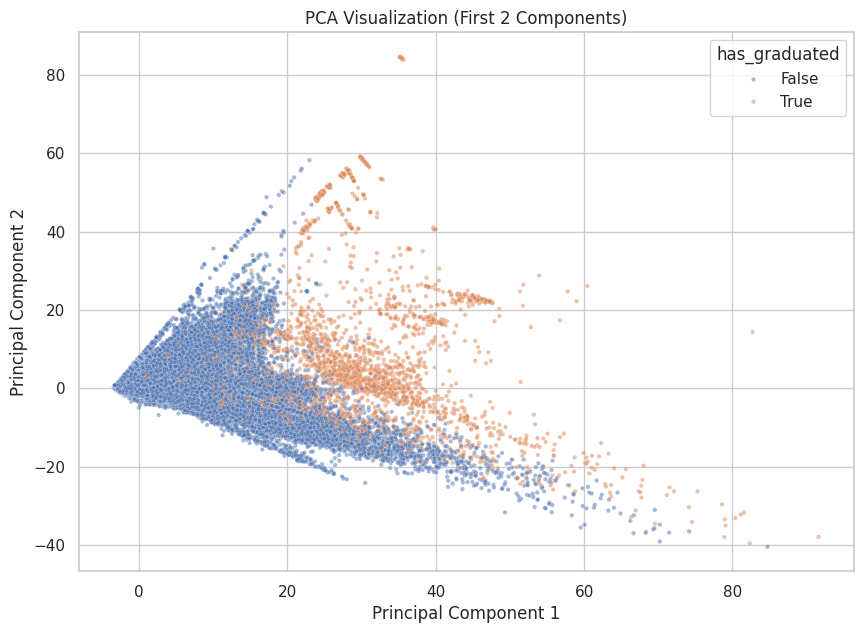

Applying UMAP (efficient and scalable)...
  Running UMAP on a sample of 10000 points.


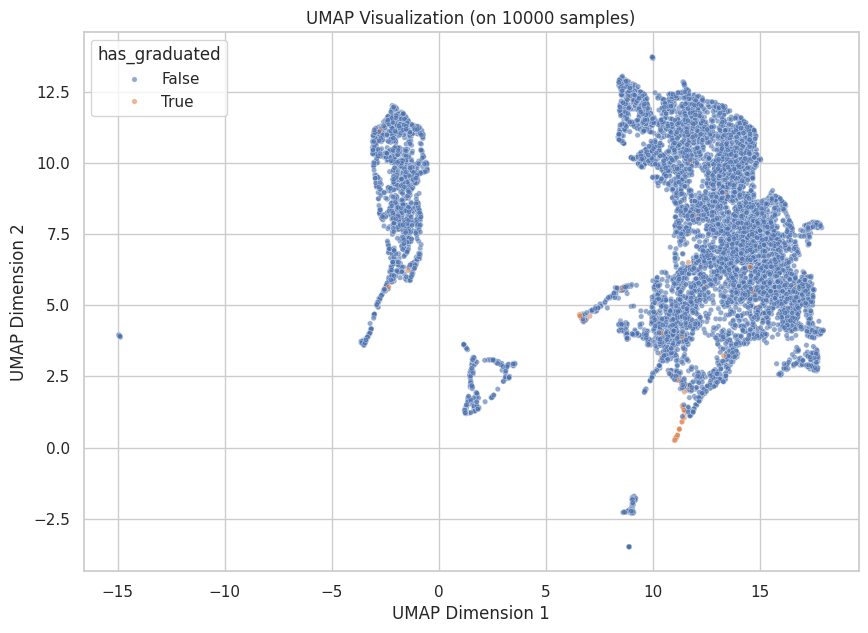

In [ ]:
print("\n--- Step 7: Dimensionality Reduction (Optional Visualization) ---")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Use only numerical features for dimensionality reduction
features_for_dim_red = numerical_cols  # Use all numerical features calculated earlier

# Remove columns with zero variance, as they break StandardScaler/PCA
zero_var_cols = train_features_df[features_for_dim_red].columns[
    train_features_df[features_for_dim_red].var() == 0
]
if len(zero_var_cols) > 0:
    print(f"Removing zero-variance columns before scaling: {zero_var_cols.tolist()}")
    features_for_dim_red = [col for col in features_for_dim_red if col not in zero_var_cols]

# Ensure we still have features left
if not features_for_dim_red:
    print("No non-zero variance numerical features available for dimensionality reduction.")
else:
    print(f"Using {len(features_for_dim_red)} features for dimensionality reduction.")
    X = train_features_df[features_for_dim_red].copy()

    # Scale features
    print("Scaling features...")
    scaler = StandardScaler()
    try:
        X_scaled = scaler.fit_transform(X)

        # PCA
        print("Applying PCA...")
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_scaled)
        print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_.sum():.3f}")

        pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'], index=X.index)
        pca_df['has_graduated'] = train_features_df['has_graduated']

        plt.figure(figsize=(10, 7))
        sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='has_graduated', alpha=0.5, s=10)
        plt.title('PCA Visualization (First 2 Components)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.show()

        # UMAP (modern alternative to t-SNE)
        print("Applying UMAP (efficient and scalable)...")
        n_umap_samples = min(len(X_scaled), 10000)  # Limit UMAP sample size
        if n_umap_samples < len(X_scaled):
            print(f"  Running UMAP on a sample of {n_umap_samples} points.")
            sample_indices = np.random.choice(len(X_scaled), n_umap_samples, replace=False)
            X_scaled_sample = X_scaled[sample_indices]
            y_sample = train_features_df['has_graduated'].iloc[sample_indices]
        else:
            X_scaled_sample = X_scaled
            y_sample = train_features_df['has_graduated']

        umap_model = umap.UMAP(n_components=2, random_state=42)
        X_umap = umap_model.fit_transform(X_scaled_sample)

        umap_df = pd.DataFrame(data=X_umap, columns=['UMAP1', 'UMAP2'])
        umap_df['has_graduated'] = y_sample.values

        plt.figure(figsize=(10, 7))
        sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='has_graduated', alpha=0.6, s=15)
        plt.title(f'UMAP Visualization (on {n_umap_samples} samples)')
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        plt.show()

    except Exception as e:
        print(f"Could not perform dimensionality reduction: {e}")


In [ ]:
# --- Step 8: Refinement & Iteration ---
print("\n--- Step 8: Refinement & Iteration ---")
print("Based on the analysis above:")
print("1. Identify Predictive Features:")
print("   - Look at the sorted correlations from Step 4 (Feature-Target Correlation).")
print("   - Examine distributions/boxplots from Step 3 where the two 'has_graduated' groups show clear separation.")
print("2. Identify Potentially Useless/Redundant Features:")
print("   - Features with very low correlation (near 0) with the target.")
print("   - Features with almost identical distributions/boxplots for both target classes.")
print("   - Highly correlated feature pairs from the Step 4 heatmap (consider keeping only one).")
print("3. Identify Features Needing Transformation:")
print("   - Highly skewed features (identified in Step 3 histograms) might benefit from log, square root, or Box-Cox transformation before certain modeling techniques.")
print("4. Consider New Feature Interactions:")
print("   - If scatter plots in Step 5 showed interesting patterns separable by target, consider creating interaction terms (e.g., feat1 * feat2).")
print("   - Example: 'sol_vol_per_wallet' = 'total_sol_vol_100s' / 'unique_wallets_count_100s' (handle division by zero).")

print("\nThis analysis informs preprocessing (scaling, transformation) and feature selection for modeling.")
print("--- Analysis Complete ---")